In [21]:
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.ticker as ticker
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean

import warnings
warnings.filterwarnings('ignore')

# Functions

In [22]:
def create_stats_for_cluster(df, df_stats,column):

    X_mean = pd.concat([pd.DataFrame(df.mean().drop(column), columns=['mean']), 
                       df.groupby(column).mean().T], axis=1)

    X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_dev_rel.drop(columns=['mean'], inplace=True)
    X_mean.drop(columns=['mean'], inplace=True)

    X_std_mean = pd.concat([pd.DataFrame(df_stats.mean().drop(column), columns=['mean']), 
                       df_stats.groupby(column).mean().T], axis=1)

    X_std_dev_rel = X_std_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_std_dev_rel.drop(columns=['mean'], inplace=True)
    X_std_mean.drop(columns=['mean'], inplace=True)
    
    return X_mean,X_dev_rel, X_std_mean, X_std_dev_rel

In [23]:
def plot_elbow(df_stats):
    fig, ax = plt.subplots()

    visualizer = KElbowVisualizer(KMeans(), k=(1,7),ax=ax)
    visualizer.fit(df_stats)

    ax.set_xticks(range(1,7))
    visualizer.show()
    plt.show()
    
    

def silhouette_scores(df_stats):
    
    silhouette_scores = []
    for k in range(2, 7):
        km = KMeans(n_clusters=k, 
                    max_iter=300, 
                    tol=1e-04, 
                    init='k-means++', 
                    n_init=10, 
                    random_state=42, 
                    algorithm='auto')
        km.fit(df_stats)
        silhouette_scores.append(silhouette_score(df_stats, km.labels_))

    fig, ax = plt.subplots()
    ax.plot(range(2, 7), silhouette_scores, 'bx-')
    ax.set_title('Silhouette Score Method')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette Scores')
    plt.xticks(range(2, 7))
    plt.tight_layout()
    plt.show()
    


def silhouette_plot(X, model, ax, colors):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper),0,values,
                         facecolor=colors[idx],edgecolor=colors[idx]
        )
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.legend(loc="best")
    return ax


def multi_silhouette_plot(df_stats):    # Plot for multiple ks
    k_max = 6
    ncols = 3
    # calculate number of rows
    nrows = k_max // ncols + (k_max % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)

    for k in range(2,k_max+1):

        # Apply clustering for k clusters
        km = KMeans(n_clusters=k, 
                    max_iter=300, 
                    tol=1e-04, 
                    init='k-means++', 
                    n_init=10, 
                    random_state=42, 
                    algorithm='auto')

        km_fit = km.fit(df_stats)

        # create chart
        ax = plt.subplot(nrows, ncols, k-1)
        silhouette_plot(df_stats, km_fit,ax, cluster_colors)

    fig.suptitle("Silhouette plots", fontsize=18, y=1)
    plt.tight_layout()
    plt.show()
    
    

def plot_magnitude_cardinality(df_stats):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

    plot_cluster_cardinality(km_fit.labels_,
                             ax=ax1,
                             title="Cardinality",
                             color=cluster_colors
                            )
    plot_cluster_magnitude(df_stats,
                           km_fit.labels_,
                           km_fit.cluster_centers_,
                           euclidean,
                           ax=ax2,
                           title="Magnitude",
                           color=cluster_colors
                          )
    plot_magnitude_vs_cardinality(df_stats,
                                  km_fit.labels_,
                                  km_fit.cluster_centers_,
                                  euclidean,
                                  color=cluster_colors[0:km_fit.n_clusters],
                                  ax=ax3, 
                                  title="Magnitude vs. Cardinality")

    fig.autofmt_xdate(rotation=0)
    plt.tight_layout()
    plt.show()

In [24]:
# Visualizing pca and pacmap
from sklearn.decomposition import PCA
import pacmap

def plot_pca_pacmap(df_stats,y, num):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)

    # PCA
    pca_scaled_std = PCA(n_components=3,random_state=42)
    X_std_pca = pca_scaled_std.fit_transform(df_stats)

    for l, c, m in zip(range(0, num), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o','p','*')):
        ax1.scatter(X_std_pca[y == l, 0],
                    X_std_pca[y == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )




    # PACMAP
    embedding = pacmap.PaCMAP(random_state=42)
    X_std_pacmap = embedding.fit_transform(df_stats.to_numpy())

    for l, c, m in zip(range(0, num), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o','p','*')):
        ax2.scatter(X_std_pacmap[y == l, 0],
                    X_std_pacmap[y == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    ax1.set_title("PCA Visualization")
    ax2.set_title("PACMAP Visualization")

    labels = np.unique(km_fit.labels_)
    labels = ["cluster "+str(l) for l in labels]
    fig.legend(labels, loc='lower center',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)
    plt.tight_layout()
    plt.show()

In [25]:
def plot_pacmap(df_stats,y,title,num):
    
    fig,ax =  plt.subplots(figsize=(12,6), dpi=200)


    # PACMAP
    embedding = pacmap.PaCMAP(random_state=42)
    X_std_pacmap = embedding.fit_transform(df_stats.to_numpy())

    for l, c, m in zip(range(0, num), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o','p','*')):
        ax.scatter(X_std_pacmap[y == l, 0],
                    X_std_pacmap[y == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=1,
                    marker=m,
                    s=60
                    )

    ax.set_title(title ,fontsize=20)
    
  
    ax.set_xlabel("PC1",fontsize=20)
    ax.set_ylabel("PC2",fontsize=20)
    ax.tick_params(labelsize=5)


    labels = np.unique(km_fit.labels_)
    labels = ["cluster "+str(l) for l in labels]
    fig.legend(labels, loc='lower center',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)
    plt.tight_layout()
    plt.show()

In [26]:
df_Clustering = pd.read_csv('data/df_clustering_analysis.csv')
df_Clustering  = df_Clustering.iloc[:,1:]
df_Clustering.head(3)

Player Team       FG%       3P%       FT%       TS%      eFG%  \
0   Alberto Abalde  RMB -0.589415  0.235142 -0.120928 -0.628269 -0.582978   
1   James Anderson  EFE  0.701159  1.083652  1.004033  0.966108  0.936283   
2  Danilo Andjusic  ASM -0.446018  0.716923  0.749325  0.498790 -0.085289   

       ORB%      DRB%      AST%  ...   ORB_p40   DRB_p40   REB_p40   AST_p40  \
0 -0.308665  0.363017 -0.054523  ... -0.286561  0.523368  0.173640  0.069137   
1  0.649505  0.865268 -0.883456  ...  0.575939  1.038888  0.916432 -0.822181   
2 -0.846175 -0.989197 -0.575263  ... -0.818672 -0.994494 -1.010797 -0.490372   

    STL_p40   BLK_p40   TOV_p40    PF_p40    AST/TO  cluster  
0 -0.415447 -0.784926  0.114621 -0.134564 -0.031573        2  
1  0.170813 -0.408176 -1.369543 -0.278294  0.069784        2  
2 -1.186736 -0.646487  0.722098  0.149163 -0.984329        1  

[3 rows x 36 columns]

### Composizione 3 Macro cluster emersi precedentemente:

In [27]:
df_Clustering.cluster.value_counts()

2    83
1    75
0    49
Name: cluster, dtype: int64

In [28]:
df_D = df_Clustering[df_Clustering['cluster']==0]
df_A = df_Clustering[df_Clustering['cluster']==1]
df_C = df_Clustering[df_Clustering['cluster']==2]

df_A_stats = df_A.iloc[:,2:]
df_C_stats = df_C.iloc[:,2:]
df_D_stats = df_D.iloc[:,2:]

df_C_stats.head(1)

FG%       3P%       FT%       TS%      eFG%      ORB%      DRB%  \
0 -0.589415  0.235142 -0.120928 -0.628269 -0.582978 -0.308665  0.363017   

       AST%      TOV%      STL%  ...   ORB_p40   DRB_p40  REB_p40   AST_p40  \
0 -0.054523  0.363668 -0.439454  ... -0.286561  0.523368  0.17364  0.069137   

    STL_p40   BLK_p40   TOV_p40    PF_p40    AST/TO  cluster  
0 -0.415447 -0.784926  0.114621 -0.134564 -0.031573        2  

[1 rows x 34 columns]

In [29]:
cluster_colors = [ '#ddb247', '#d15252', '#1d4a60', '#cd7e59','#b4d2b1','#b4d2b1']

# Analisi CLUSTERING A - 1 

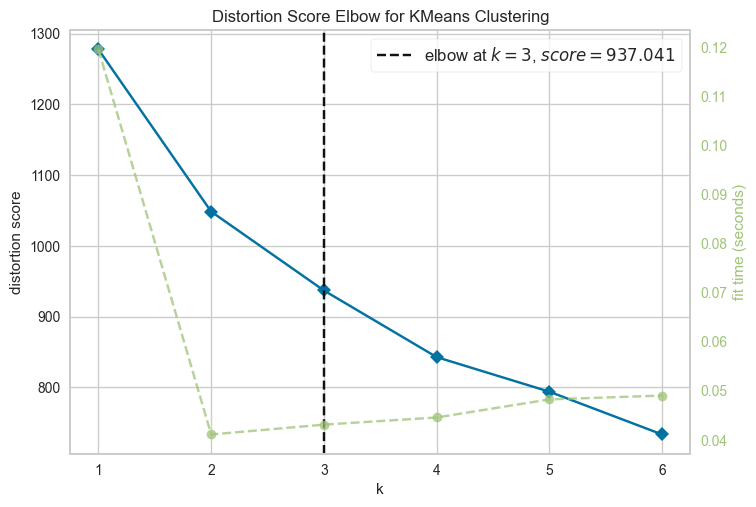

In [11]:
plot_elbow(df_A_stats)

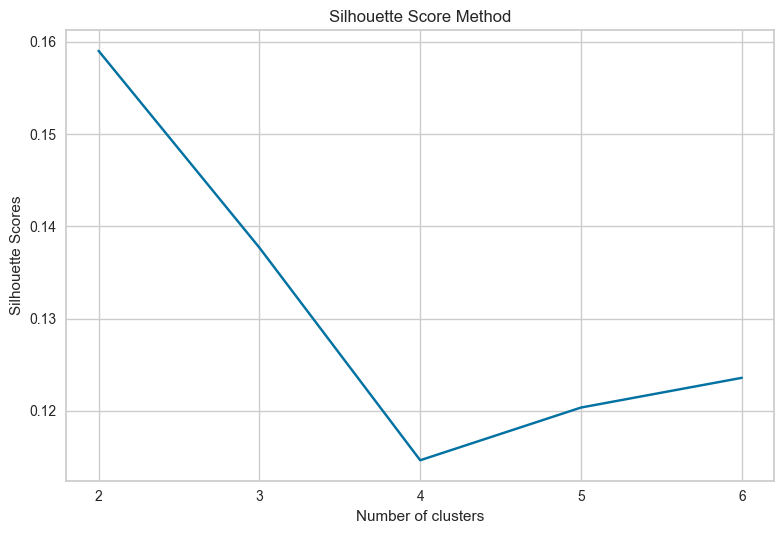

In [30]:
silhouette_scores(df_A_stats)

In [31]:
df_A_stats.shape

(75, 34)

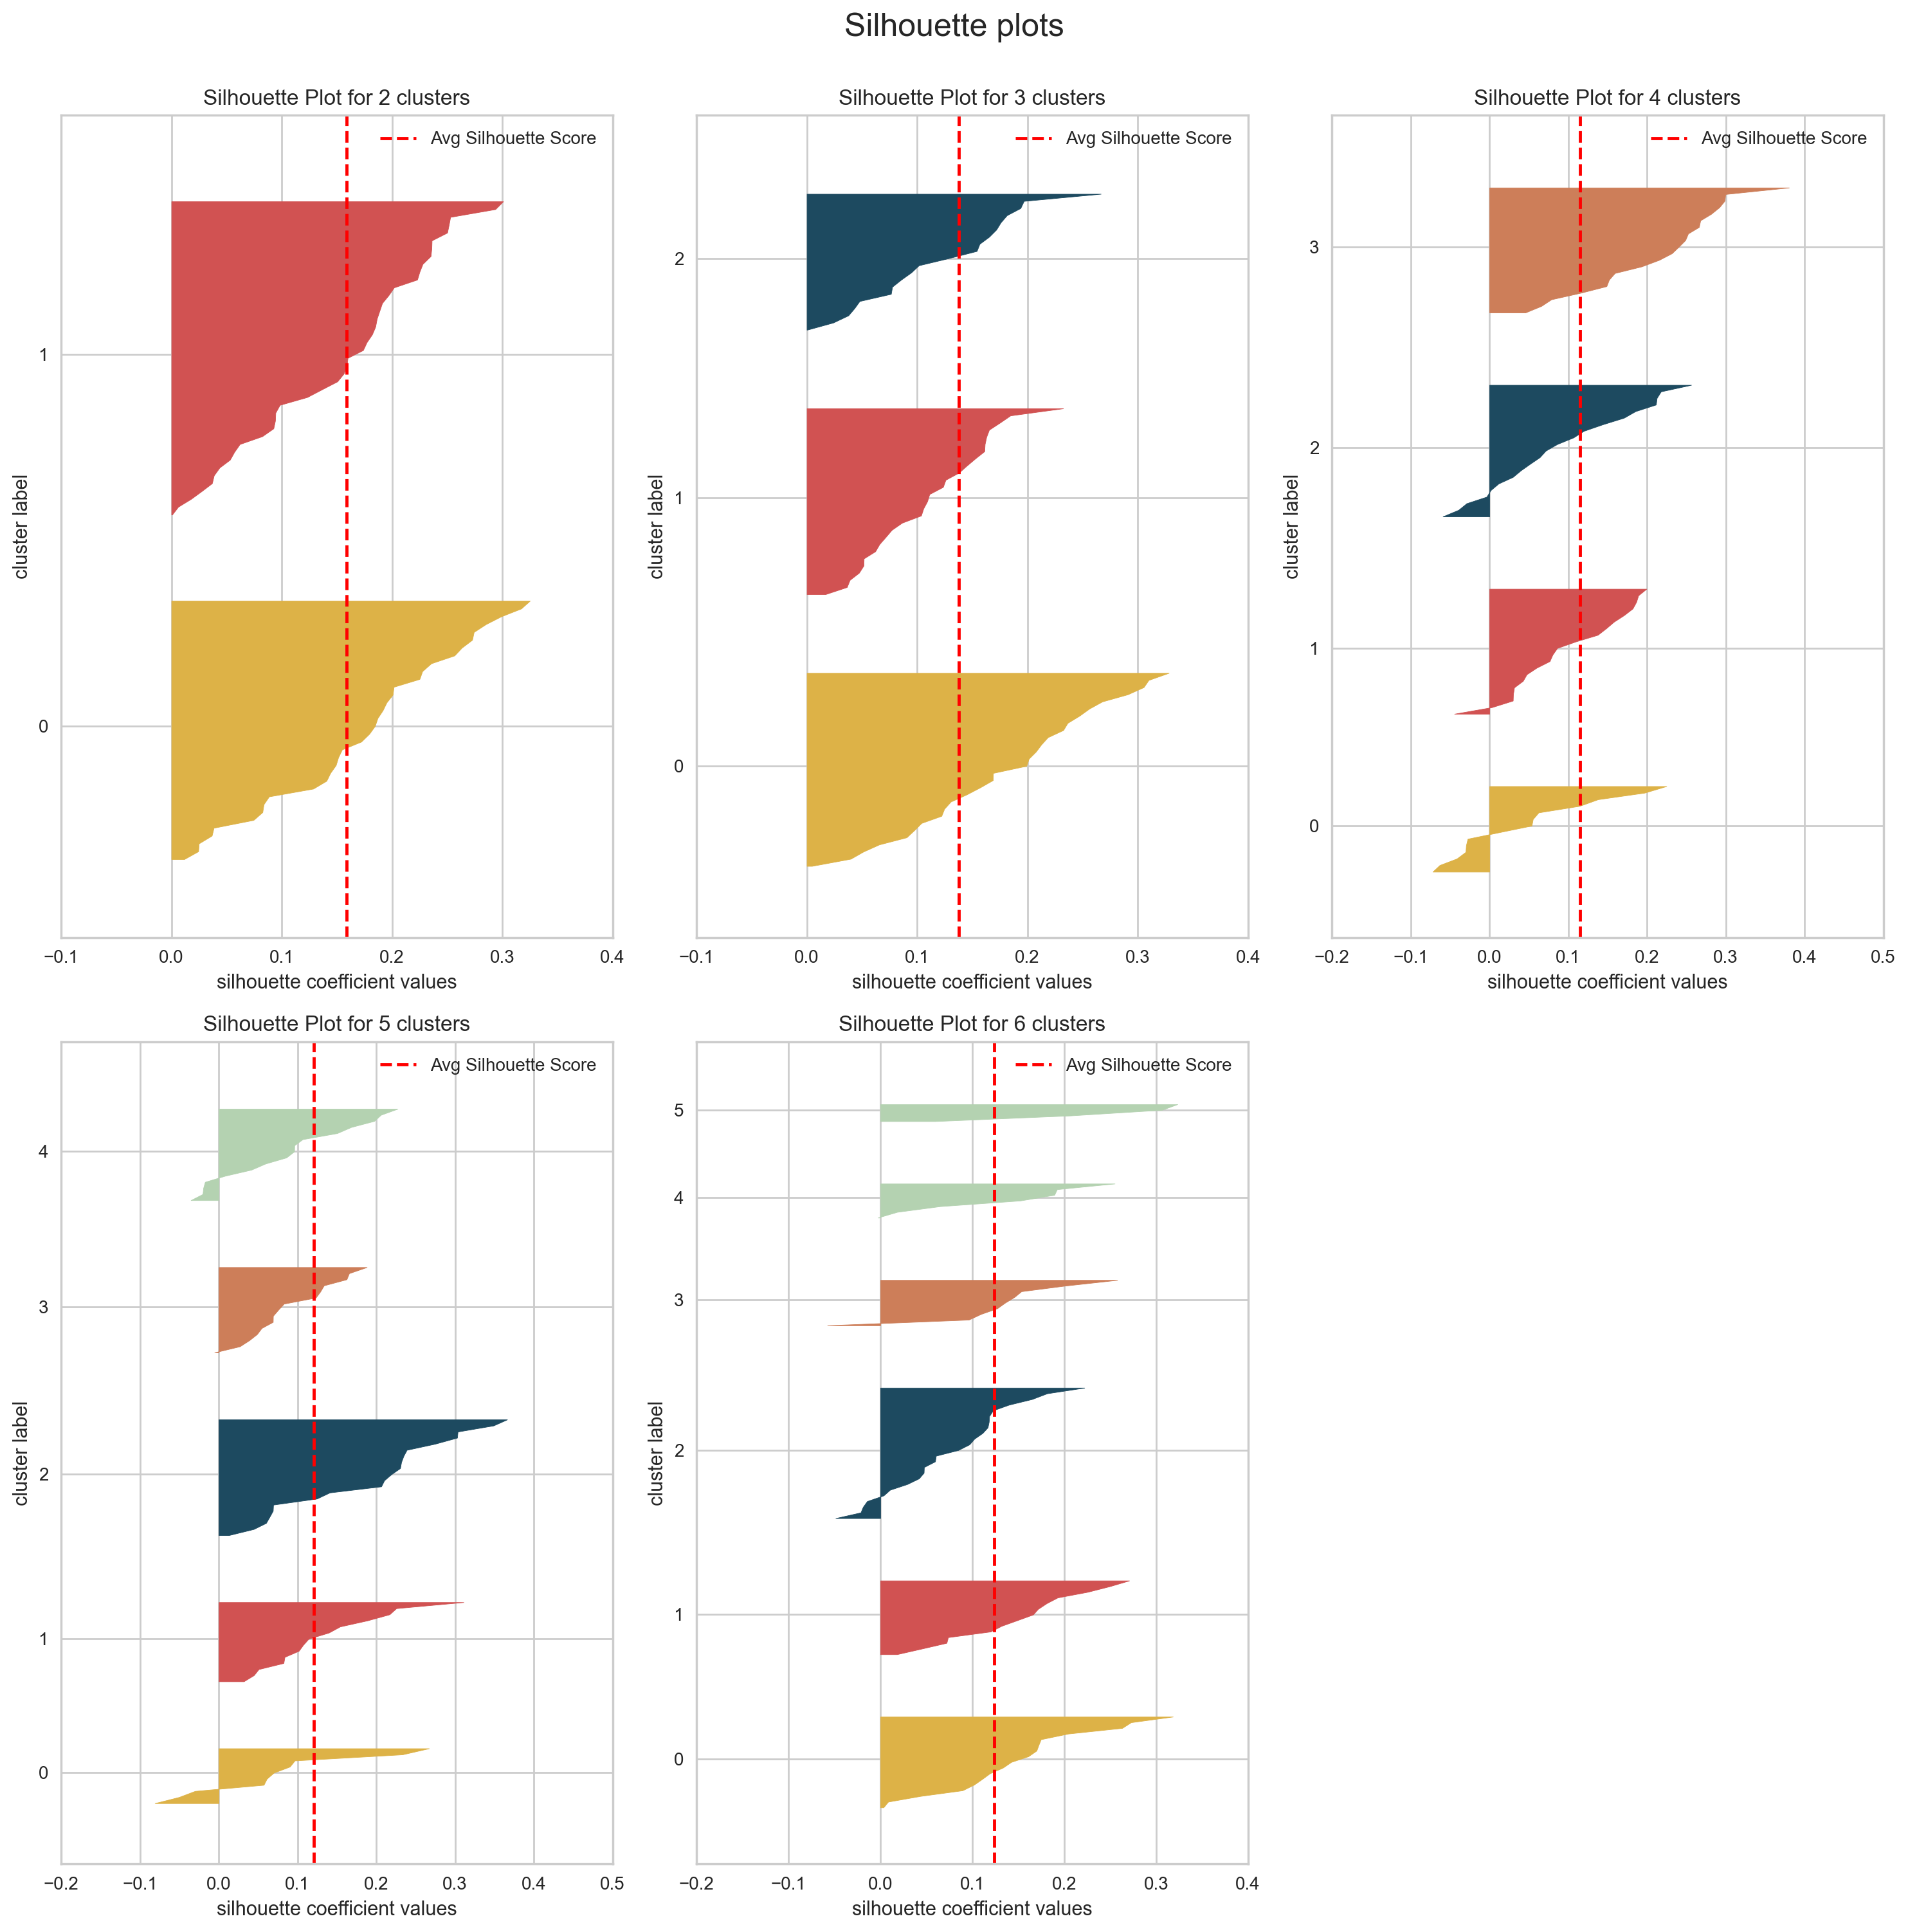

In [32]:
multi_silhouette_plot(df_A_stats)

## Dalle 3 tecniche precedenti mi viene suggerita una suddivisione in 3 cluster

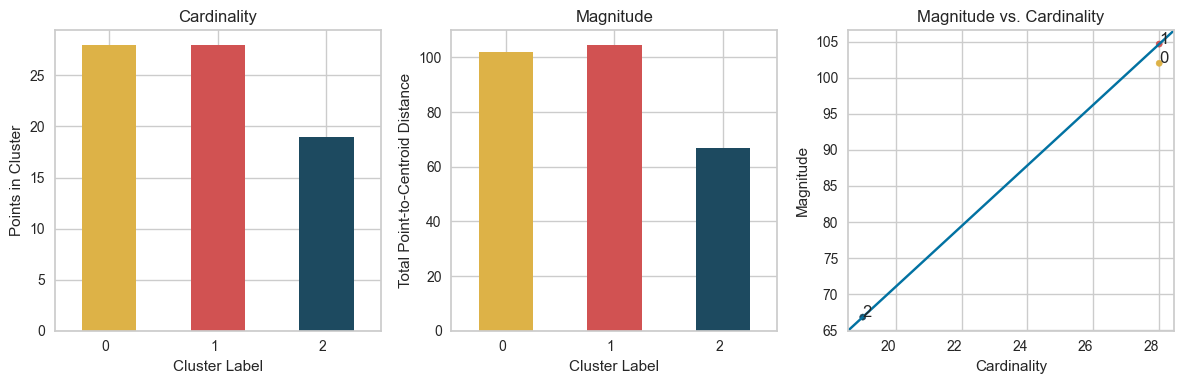

In [59]:
# Final decision
km = KMeans(n_clusters=3, 
            max_iter=300, 
            tol=1e-04, 
            init='k-means++', 
            n_init=10, 
            random_state=42, 
            algorithm='auto')

km_fit = km.fit(df_A_stats)

plot_magnitude_cardinality(df_A_stats)

In [60]:
df_A['skills_cluster'] = km.labels_
df_A_stats['skills_cluster'] = km.labels_

In [61]:
y_A = df_A_stats.skills_cluster

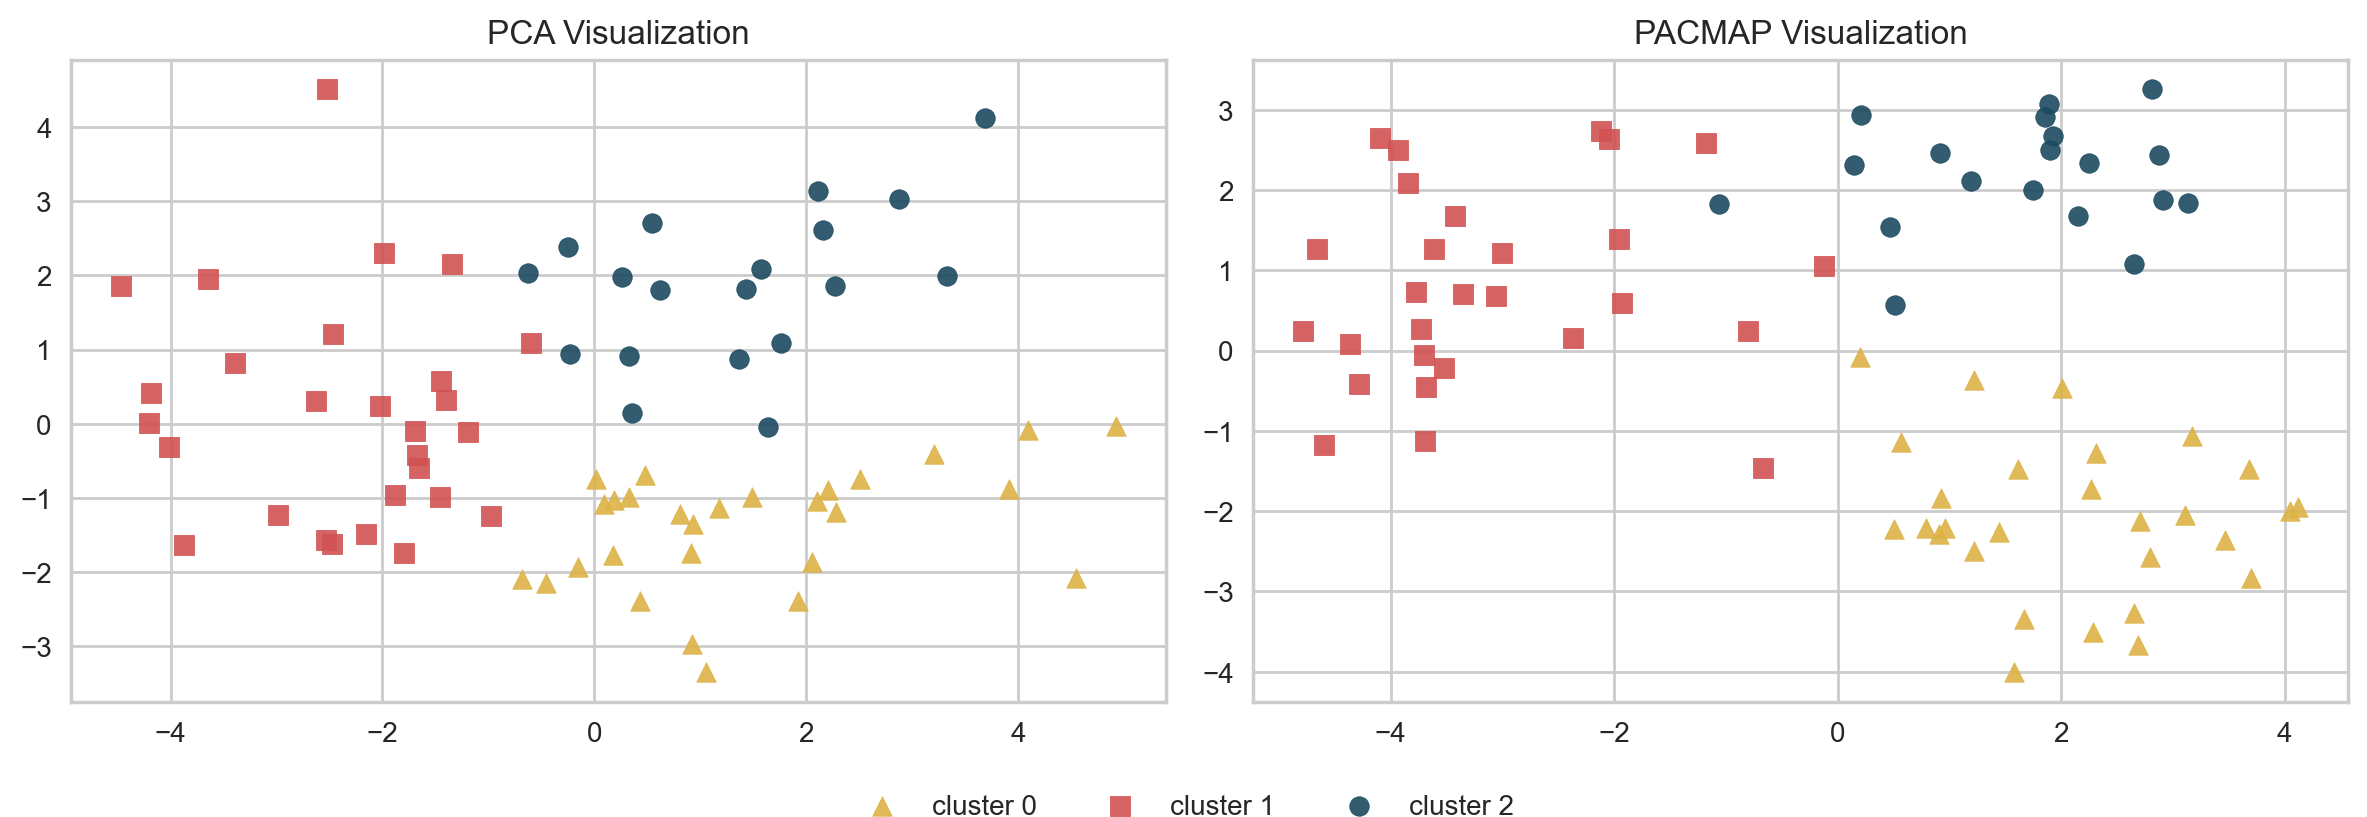

In [62]:
plot_pca_pacmap(df_A_stats,y_A, 3)

### Come si suddividono i 3 cluster emersi dentro il macro cluster A?

In [63]:
df_A['skills_cluster'].value_counts()

0    28
1    28
2    19
Name: skills_cluster, dtype: int64

***
# Analisi Metriche all'interno del macro Cluster A - 1 

In [64]:
df_final_A_stats =  df_A.iloc[:,2:]
df_final_A_stats = df_final_A_stats.drop(columns=['cluster'])



df1,df2,df3,df4 = create_stats_for_cluster(df_A , df_final_A_stats,column='skills_cluster')

### Quali statistiche impattano maggiormente per cluster 0 sul macroCluster A?

<AxesSubplot: >

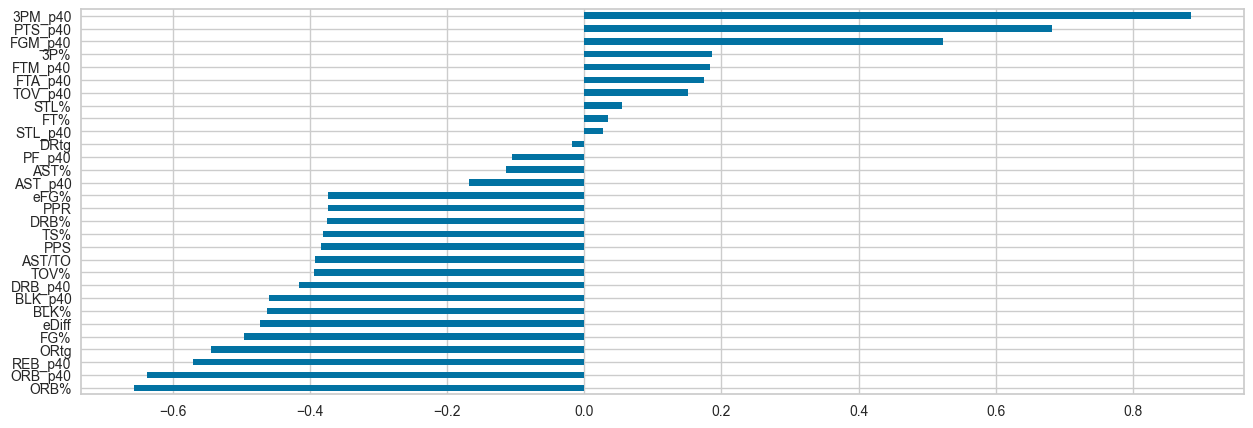

In [65]:
df3[0].sort_values(0,ascending=True).head(30).plot.barh(figsize=(15,5))

### Quali statistiche impattano maggiormente per cluster 1 sul macroCluster A?

<AxesSubplot: >

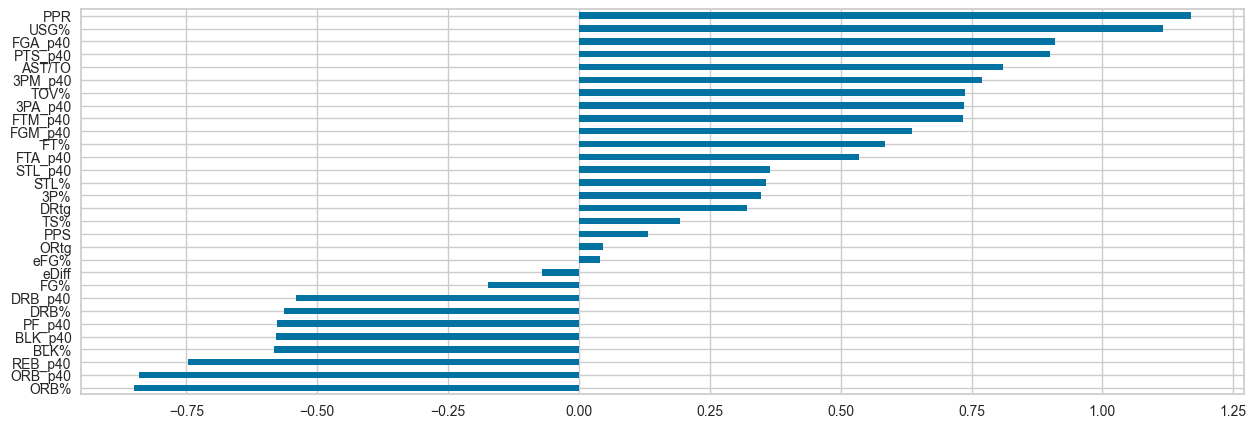

In [66]:
df3[1].sort_values(0,ascending=True).head(30).plot.barh(figsize=(15,5))

### Quali statistiche impattano maggiormente per cluster 2 sul macroCluster A?

<AxesSubplot: >

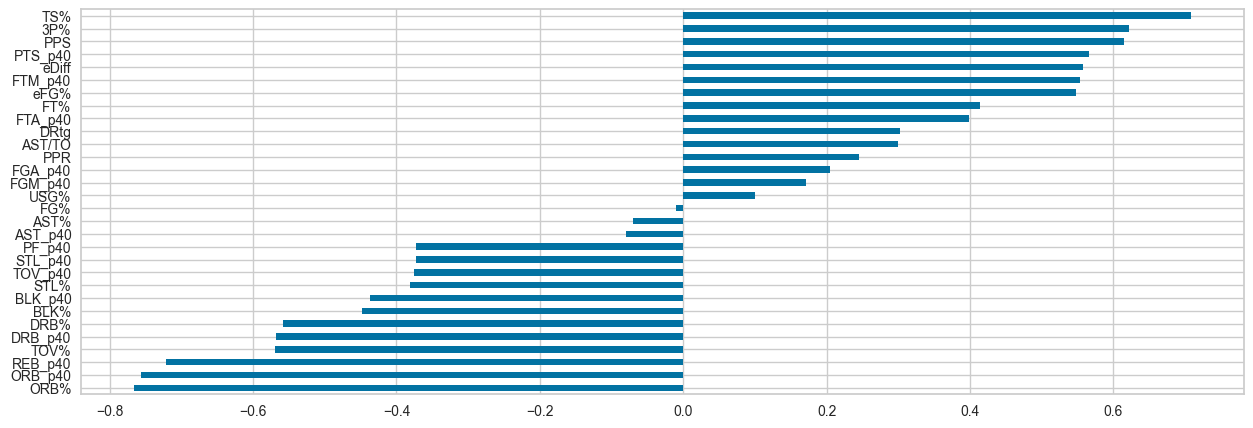

In [67]:
df3[2].sort_values(0,ascending=True).head(30).plot.barh(figsize=(15,5))

***
***
# Analisi Metriche all'interno del macro Cluster D - 0

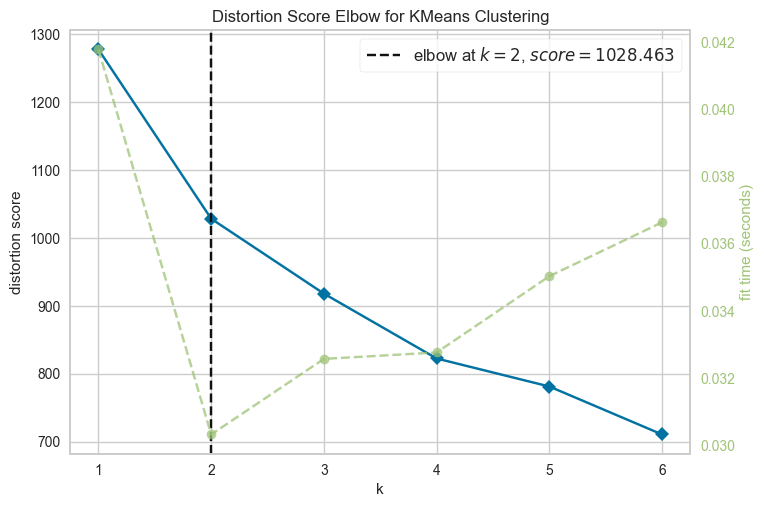

In [68]:
plot_elbow(df_D_stats)

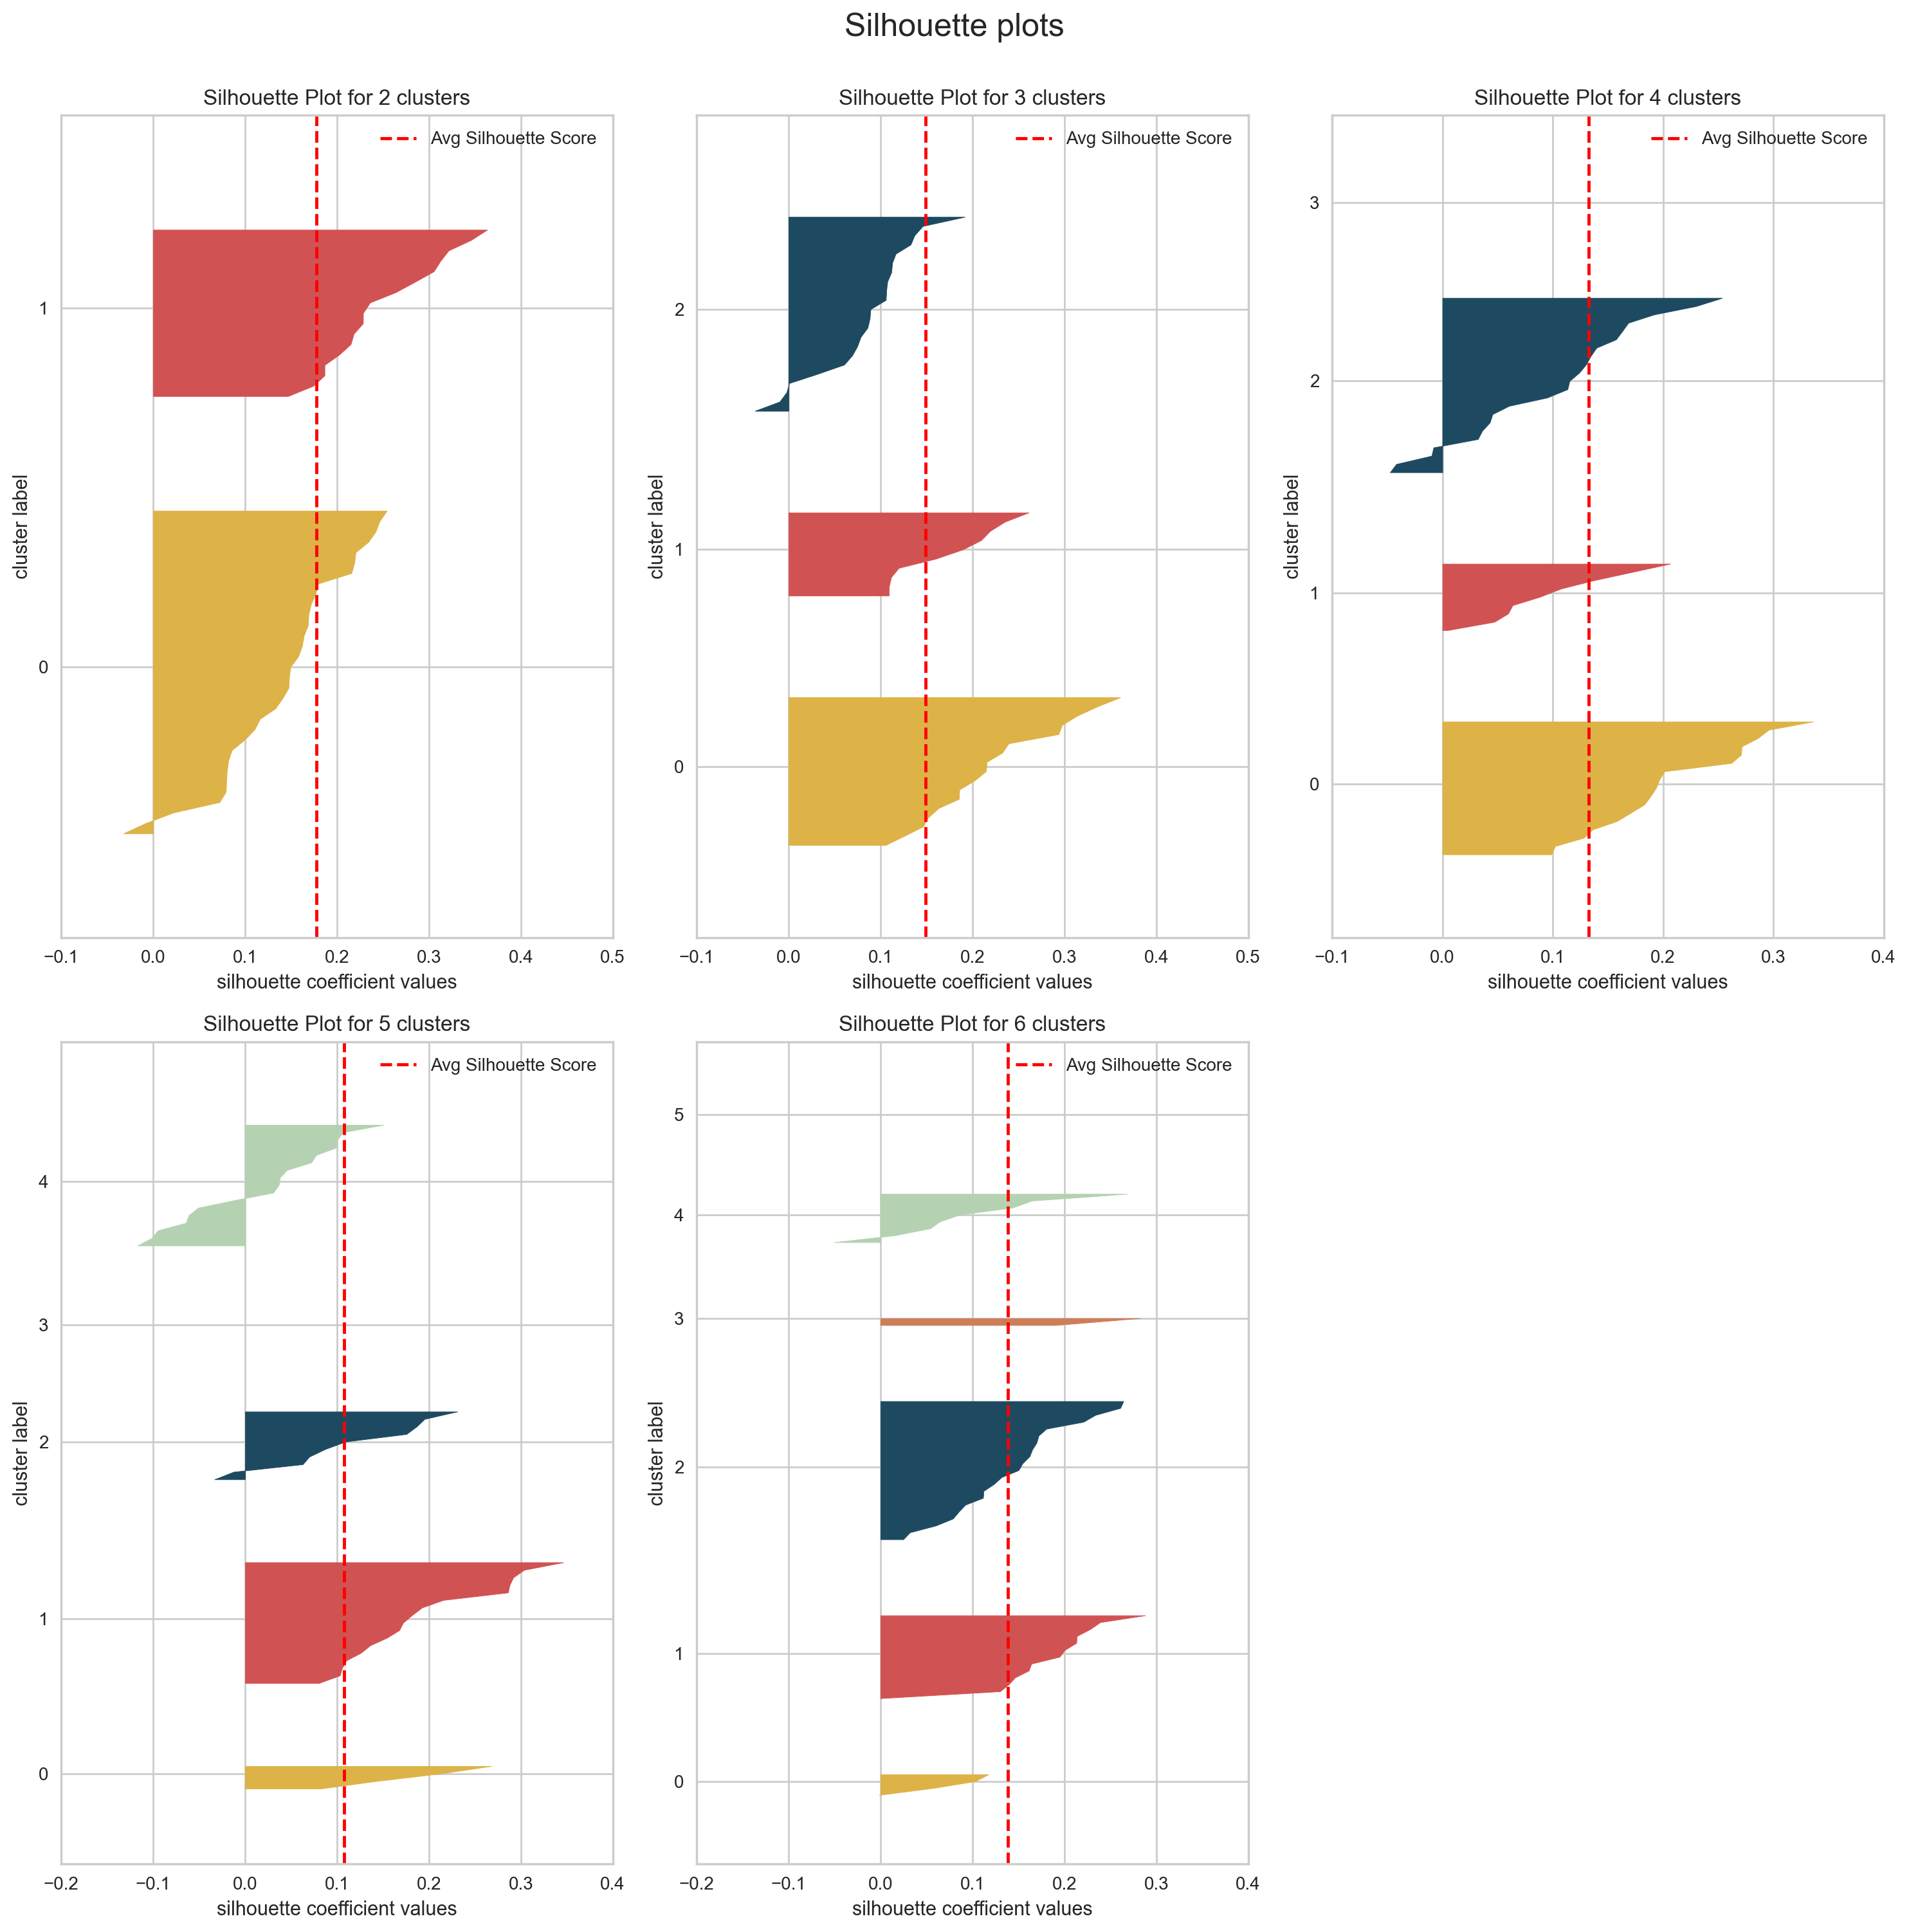

In [69]:
multi_silhouette_plot(df_D_stats)

## Anche in questo caso mi viene suggerita una suddivisione in 2

In [70]:
# Final decision
km = KMeans(n_clusters=2, 
            max_iter=300, 
            tol=1e-04, 
            init='k-means++', 
            n_init=10, 
            random_state=42, 
            algorithm='auto')

km_fit = km.fit(df_D_stats)

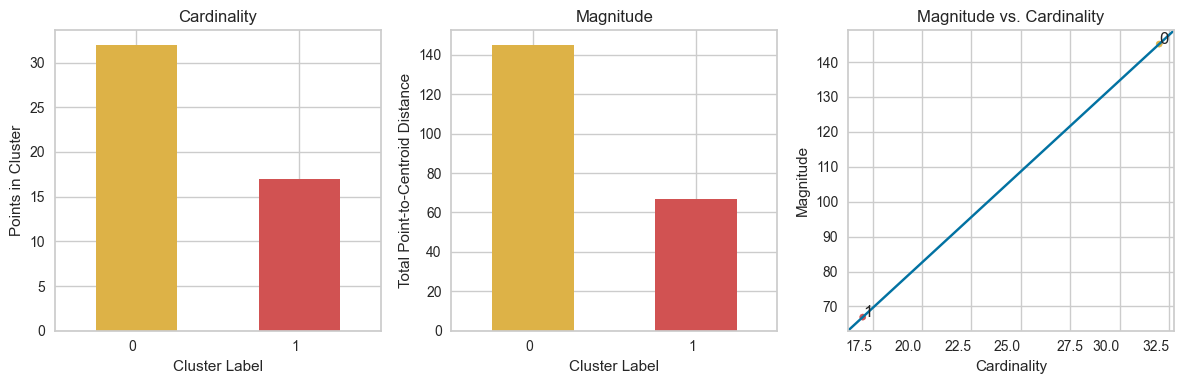

In [71]:
plot_magnitude_cardinality(df_D_stats)

In [72]:
df_D['skills_cluster'] = km.labels_
df_D_stats['skills_cluster'] = km.labels_

In [73]:
y_D = df_D_stats.skills_cluster

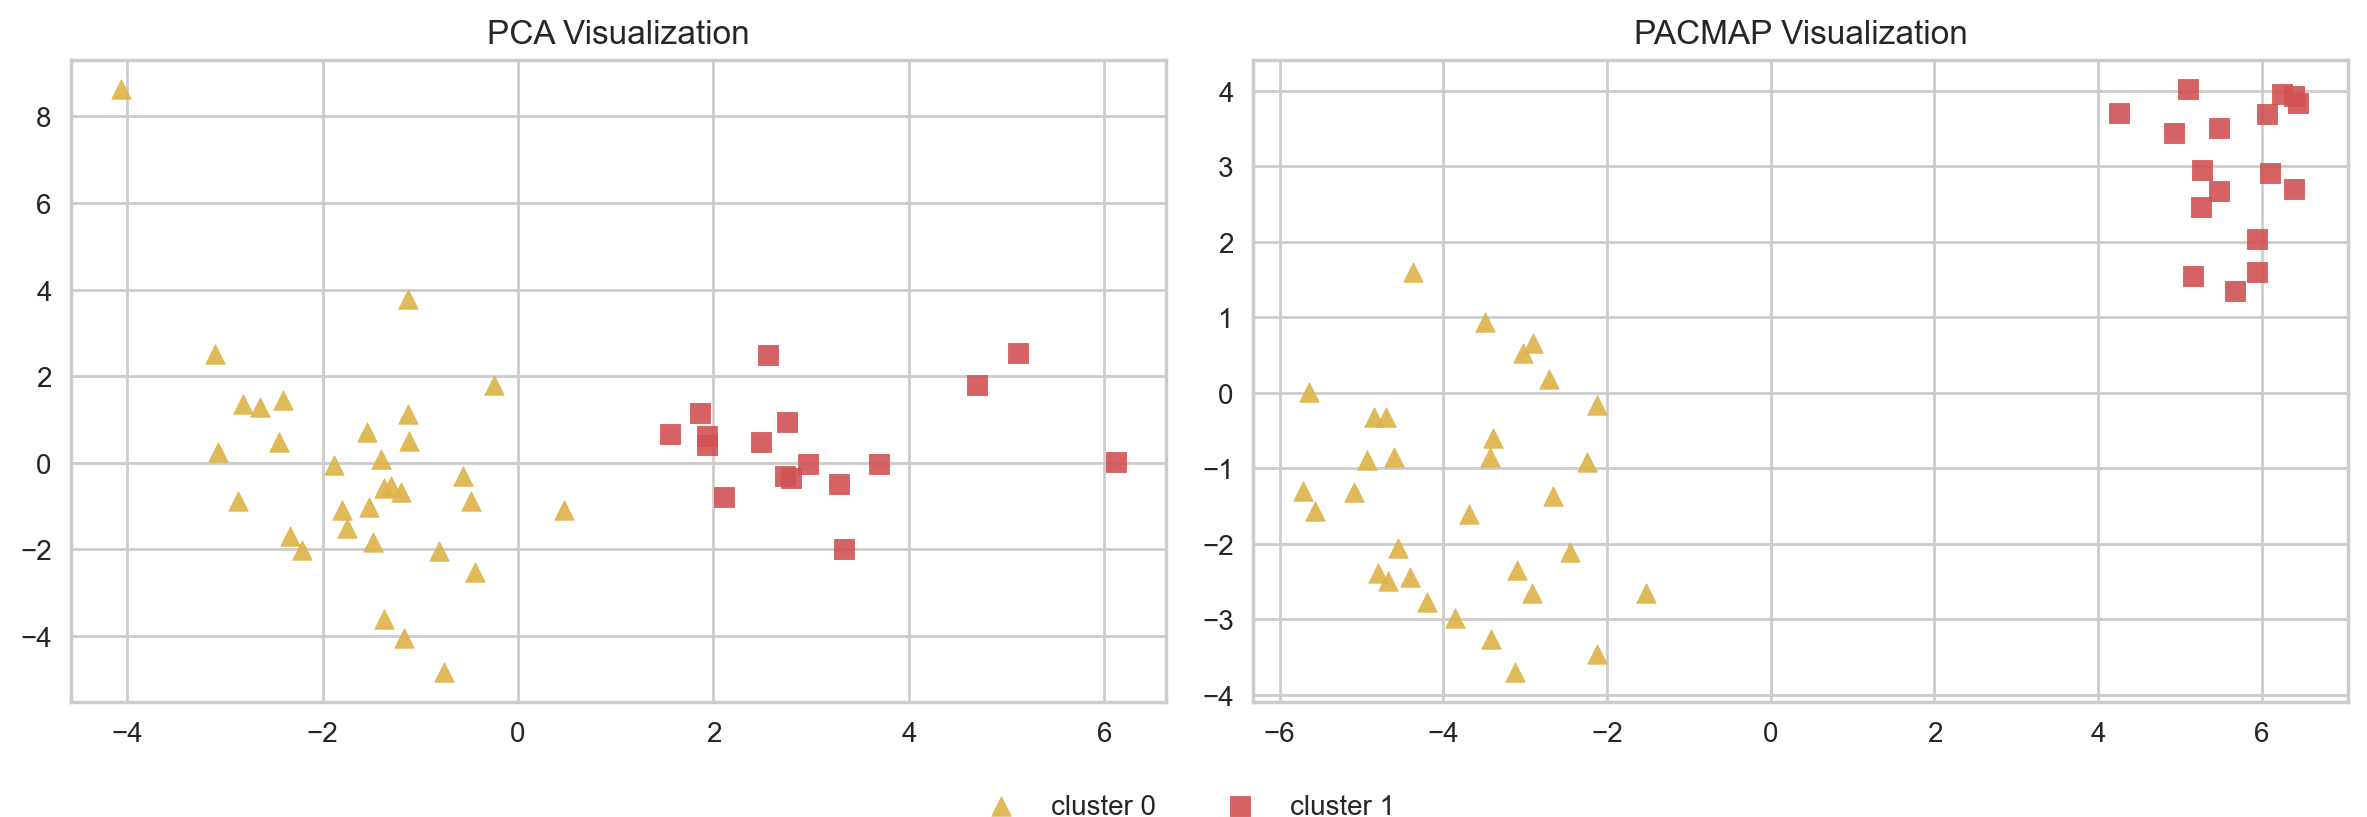

In [74]:
plot_pca_pacmap(df_D_stats,y_D, 3)

### Come si suddividono i 2 cluster emersi dentro il macro cluster D?

In [75]:
df_D['skills_cluster'].value_counts()

0    32
1    17
Name: skills_cluster, dtype: int64

***
# Analisi Metriche all'interno del macro Cluster D

In [76]:
df_final_D_stats =  df_D.iloc[:,2:]
df_final_D_stats = df_final_D_stats.drop(columns=['cluster'])



df1,df2,df3,df4 = create_stats_for_cluster(df_D , df_final_D_stats,column='skills_cluster')

### Quali statistiche impattano maggiormente per cluster 0 sul macro Cluster D?

<AxesSubplot: >

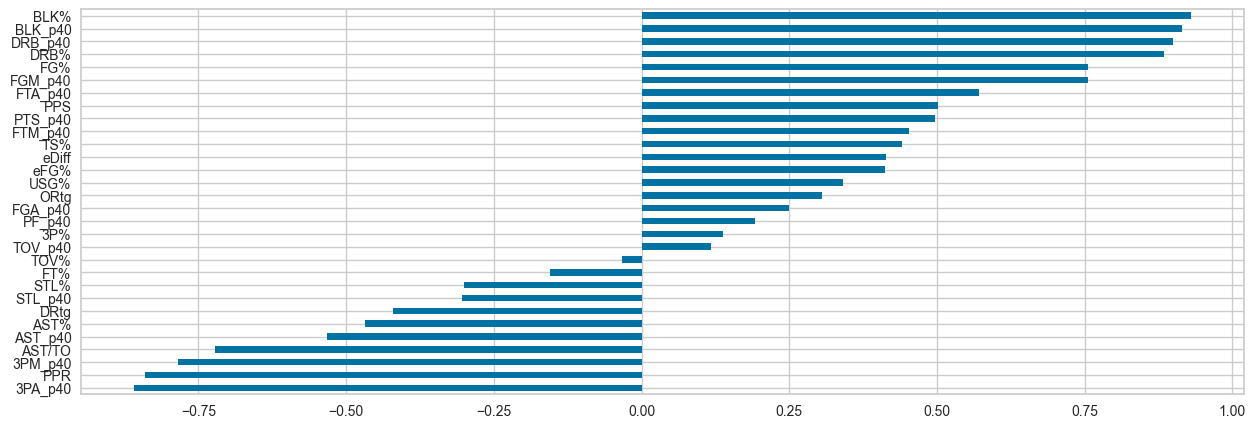

In [77]:
df3[0].sort_values(0,ascending=True).head(30).plot.barh(figsize=(15,5))

### Quali statistiche impattano maggiormente per cluster 1 sul macro Cluster D?

<AxesSubplot: >

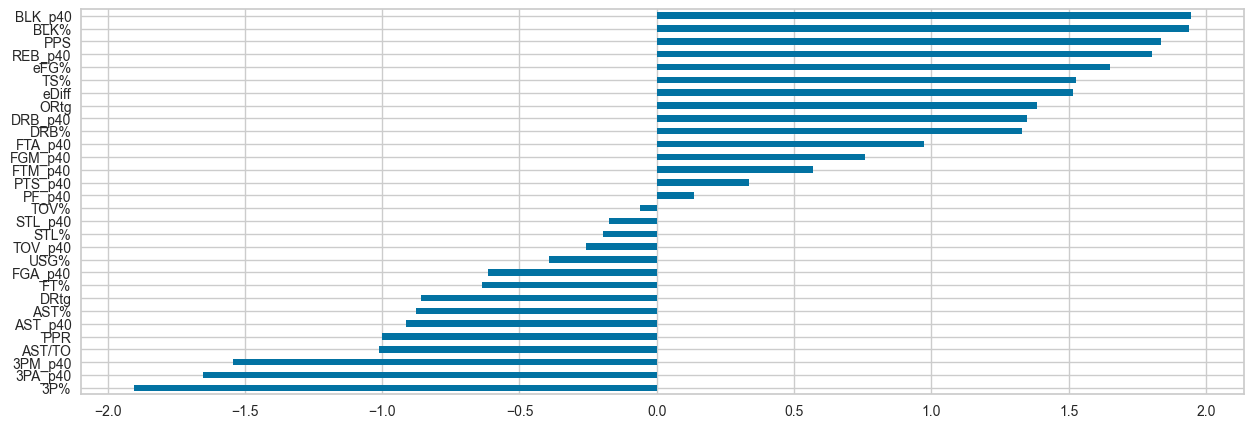

In [78]:
df3[1].sort_values(0,ascending=True).head(30).plot.barh(figsize=(15,5))


***
***
***
# Analisi CLUSTERING macro Cluster C - 2 

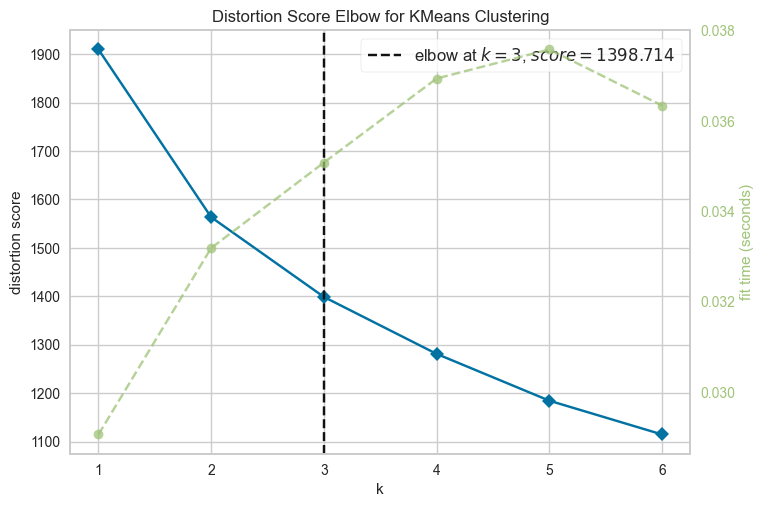

In [80]:
plot_elbow(df_C_stats)

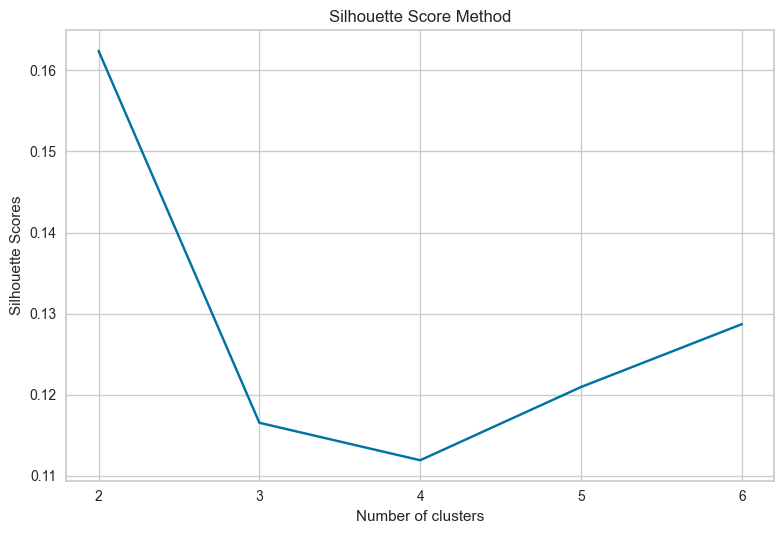

In [81]:
silhouette_scores(df_C_stats)

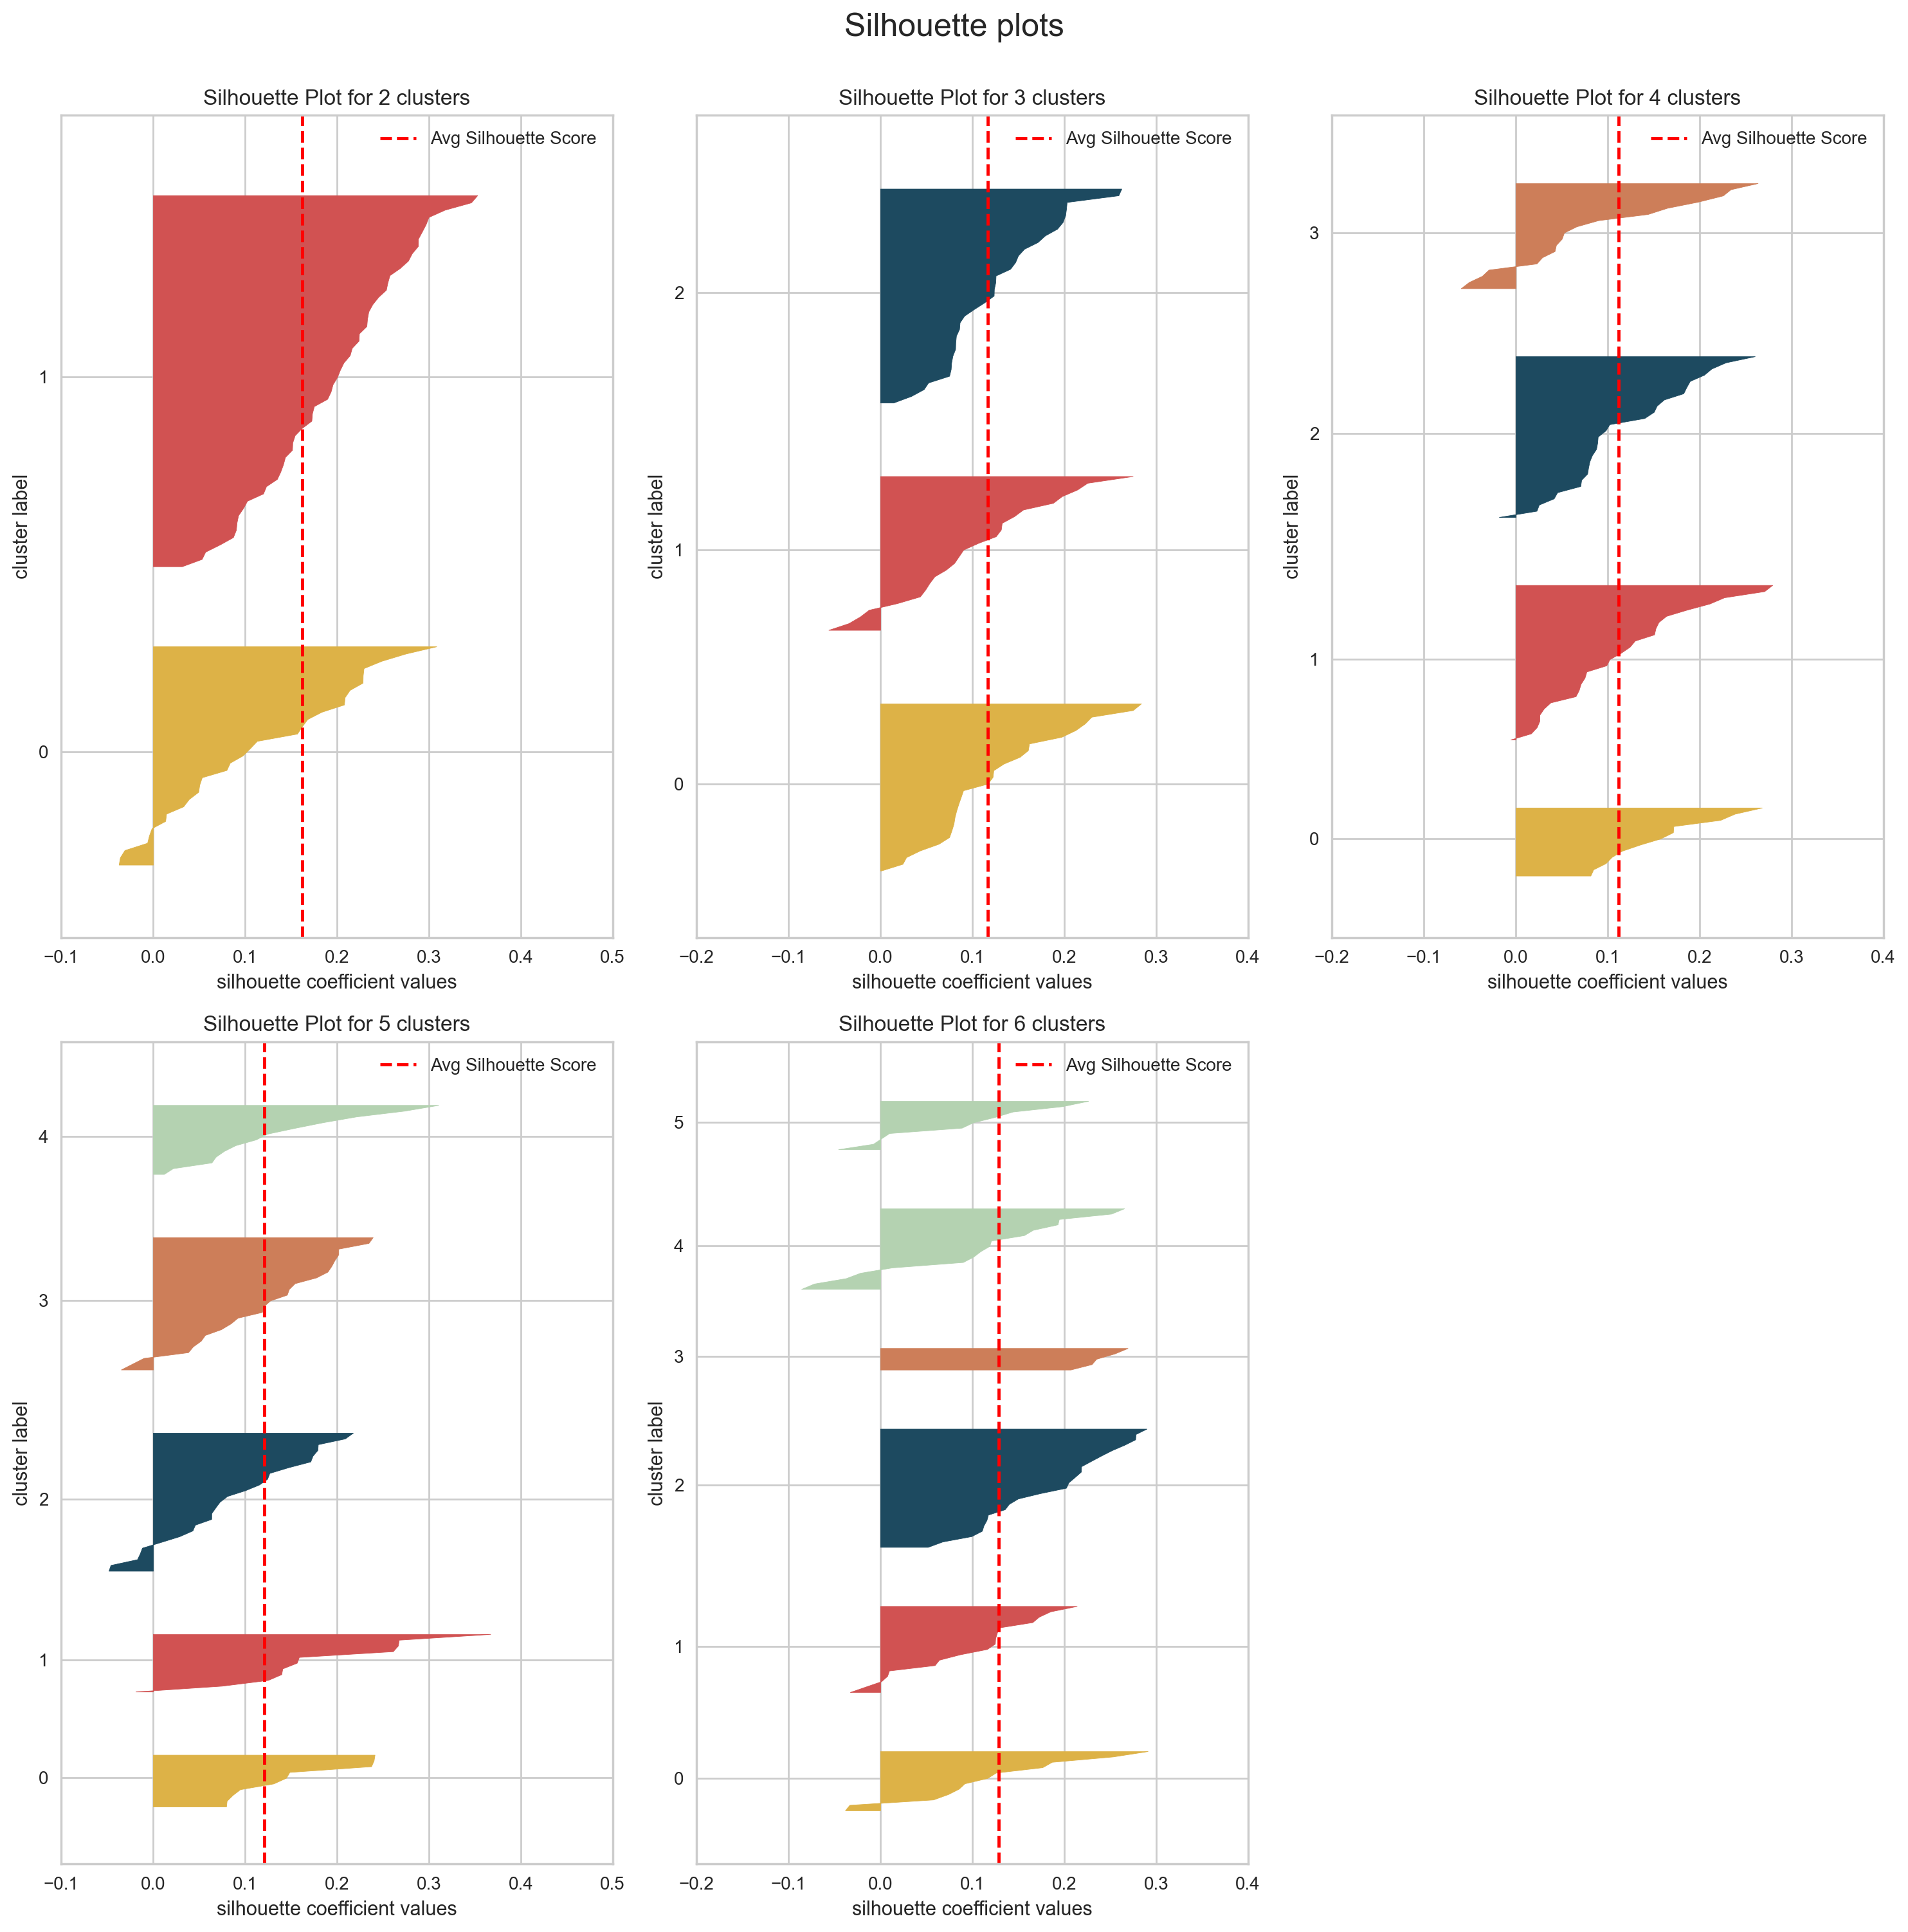

In [82]:
multi_silhouette_plot(df_C_stats)

In [83]:
# Final decision
km = KMeans(n_clusters=3, 
            max_iter=300, 
            tol=1e-04, 
            init='k-means++', 
            n_init=10, 
            random_state=42, 
            algorithm='auto')

km_fit = km.fit(df_C_stats)

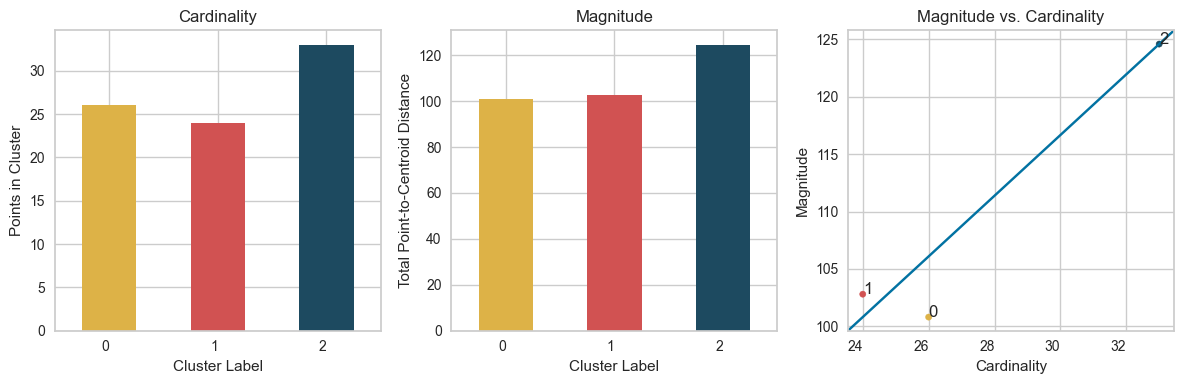

In [84]:
plot_magnitude_cardinality(df_C_stats)

In [85]:
df_C['skills_cluster'] = km.labels_
df_C_stats['skills_cluster'] = km.labels_

In [86]:
y_C = df_C_stats.skills_cluster

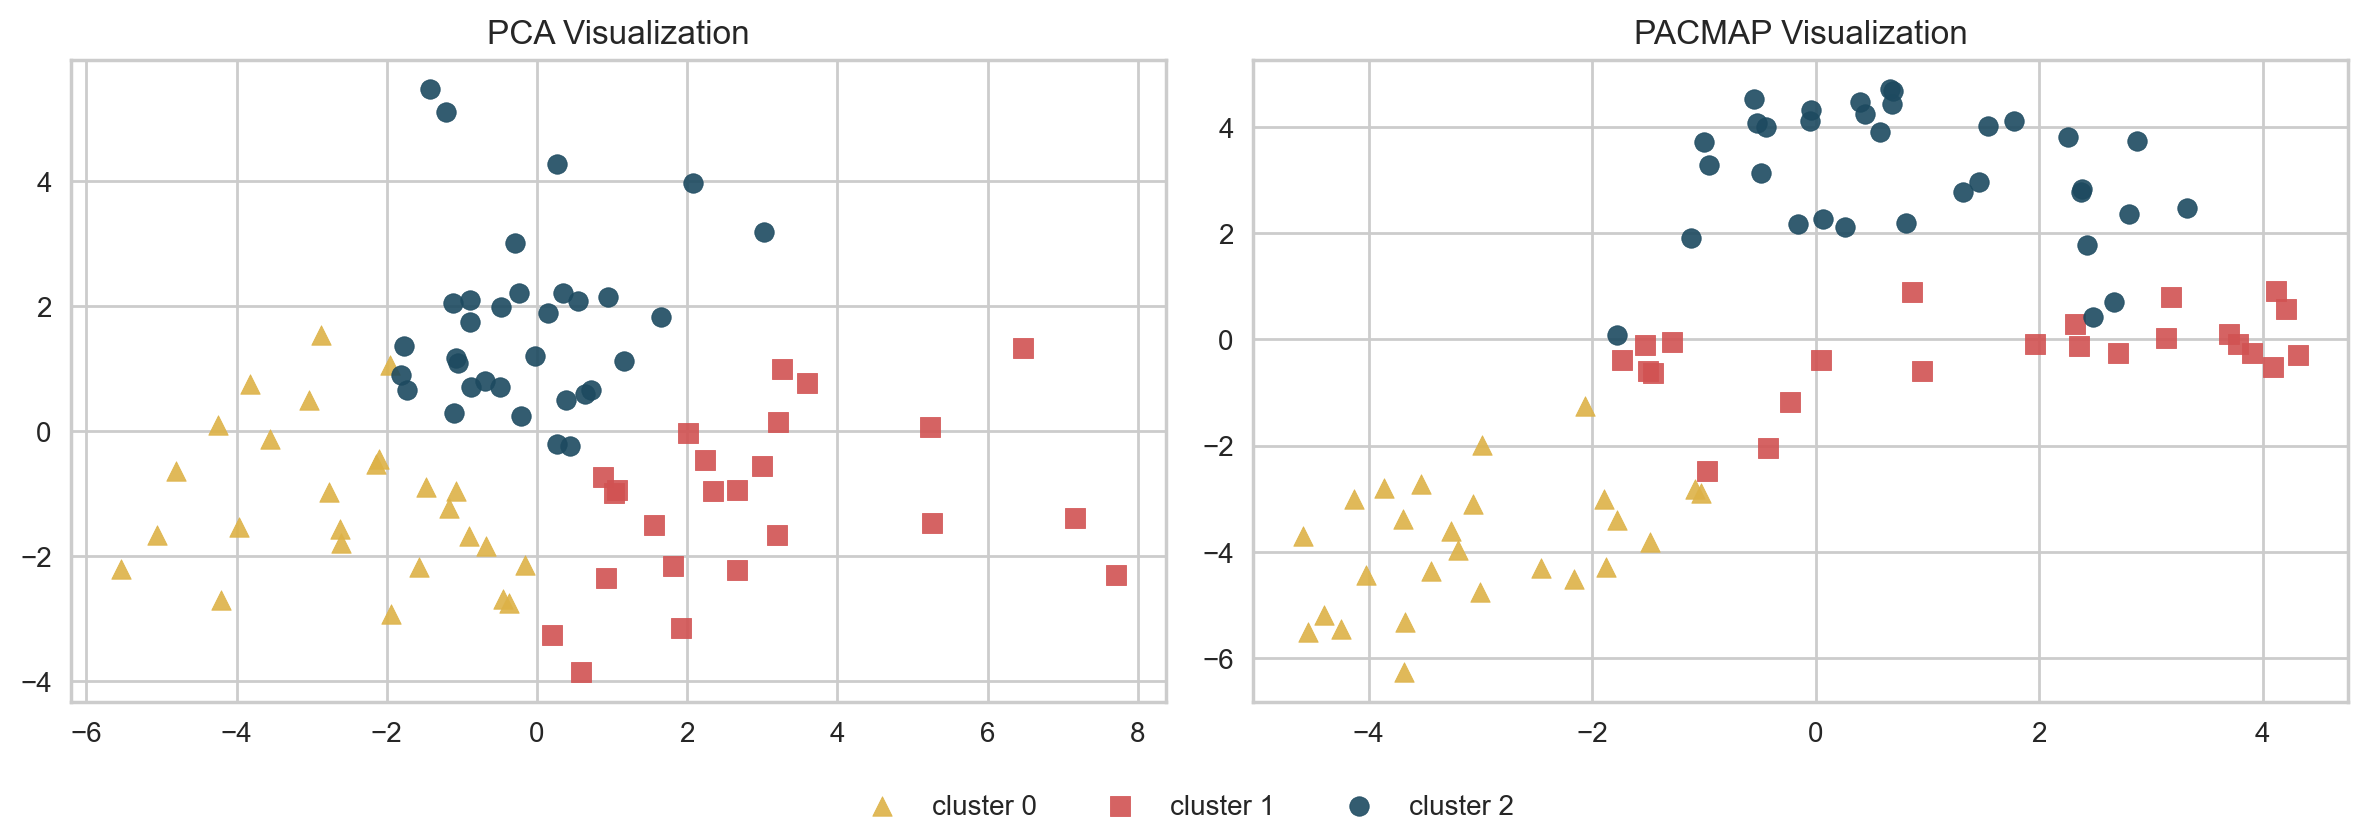

In [88]:
plot_pca_pacmap(df_C_stats,y_C, 3)

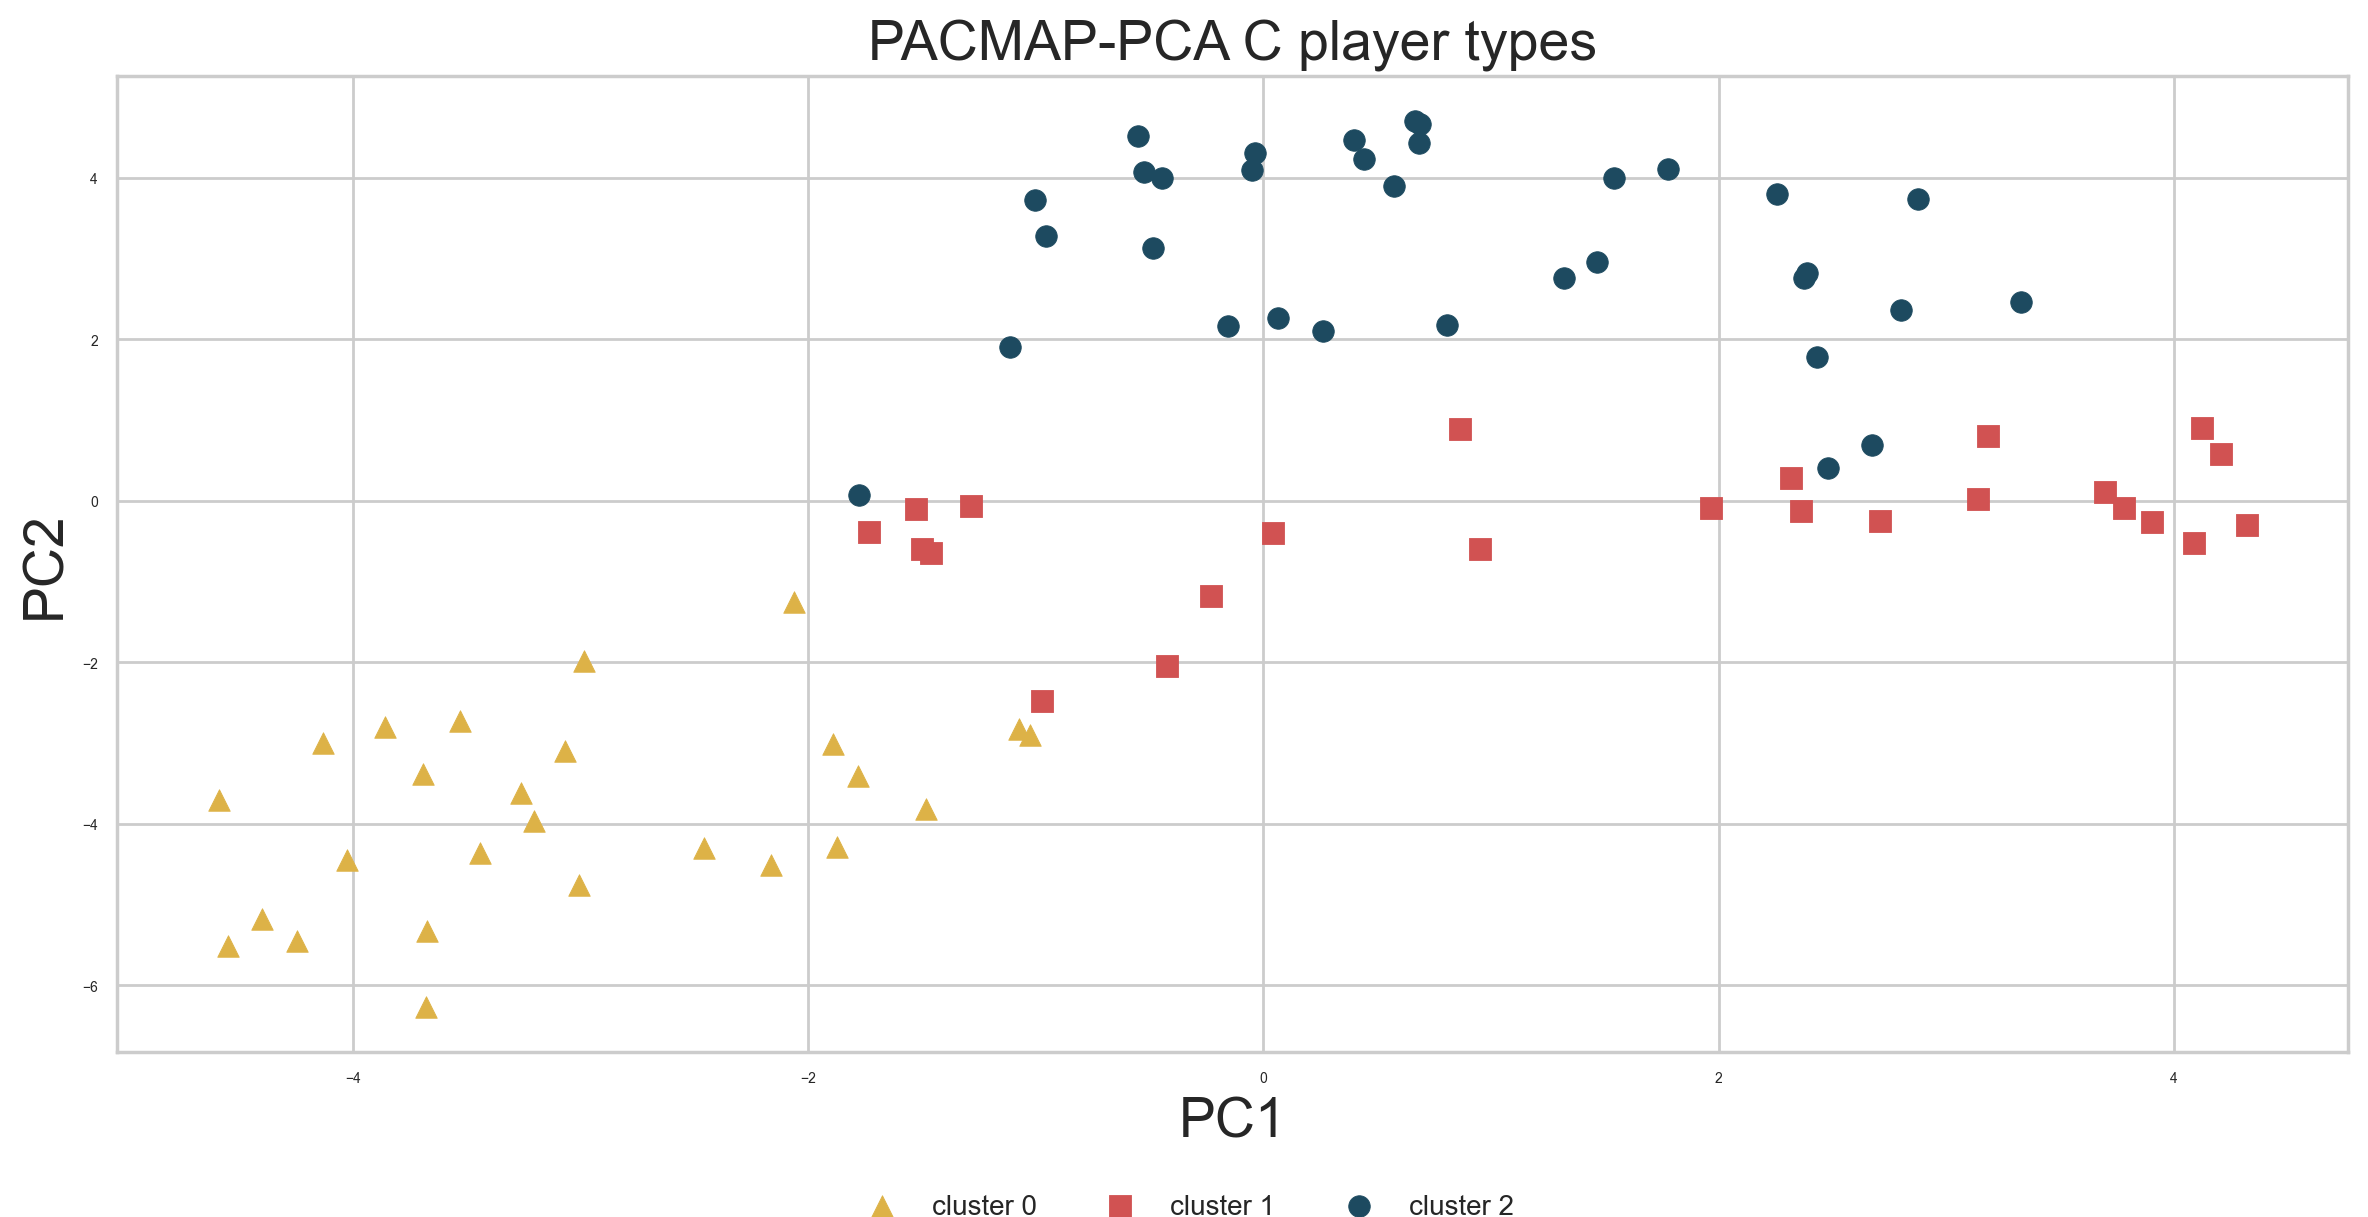

In [89]:
plot_pacmap(df_C_stats,y_C, title= "PACMAP-PCA C player types", num=3)

## Suddivisione cluster all'interno del macroCluster C

In [90]:
df_C['skills_cluster'].value_counts()

2    33
0    26
1    24
Name: skills_cluster, dtype: int64

In [91]:
df_final_C_stats =  df_C.iloc[:,2:]
df_final_C_stats = df_final_C_stats.drop(columns=['cluster'])


df1,df2,df3,df4 = create_stats_for_cluster(df_C , df_final_C_stats,column='skills_cluster')

### Quali statistiche impattano maggiormente per cluster 0 sul dfC?

<AxesSubplot: >

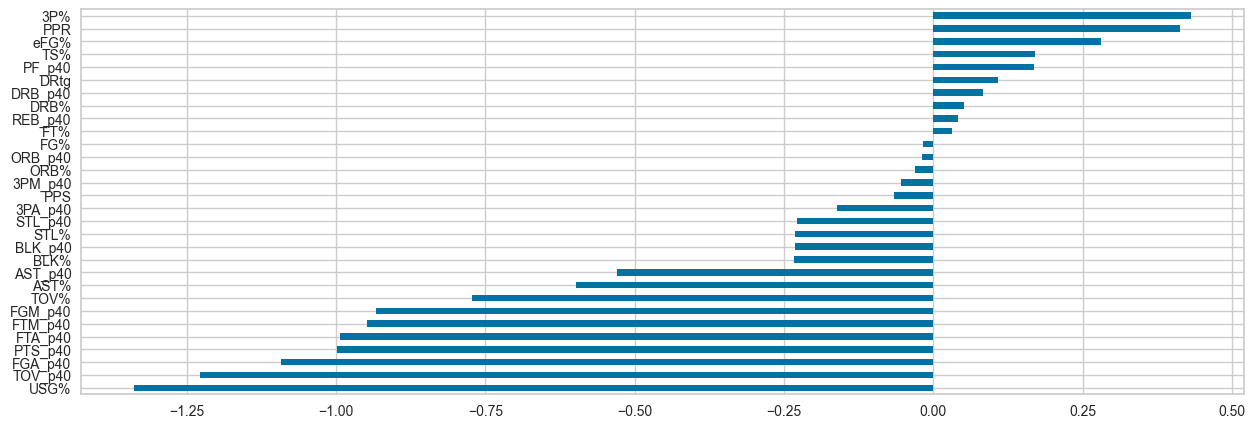

In [92]:
df3[0].sort_values(0,ascending=True).head(30).plot.barh(figsize=(15,5))

<AxesSubplot: >

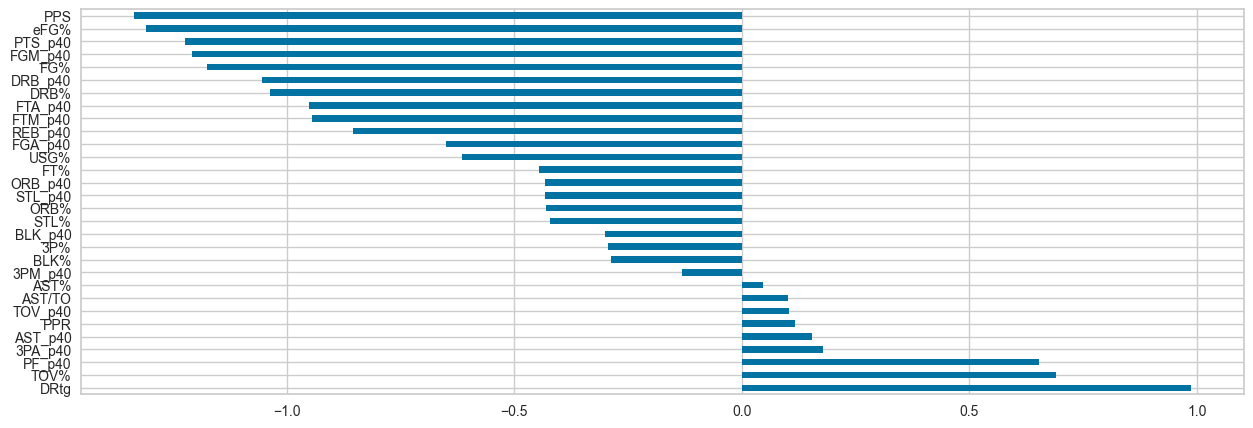

In [93]:
df3[1].sort_values(0,ascending=False).head(30).plot.barh(figsize=(15,5))

<AxesSubplot: >

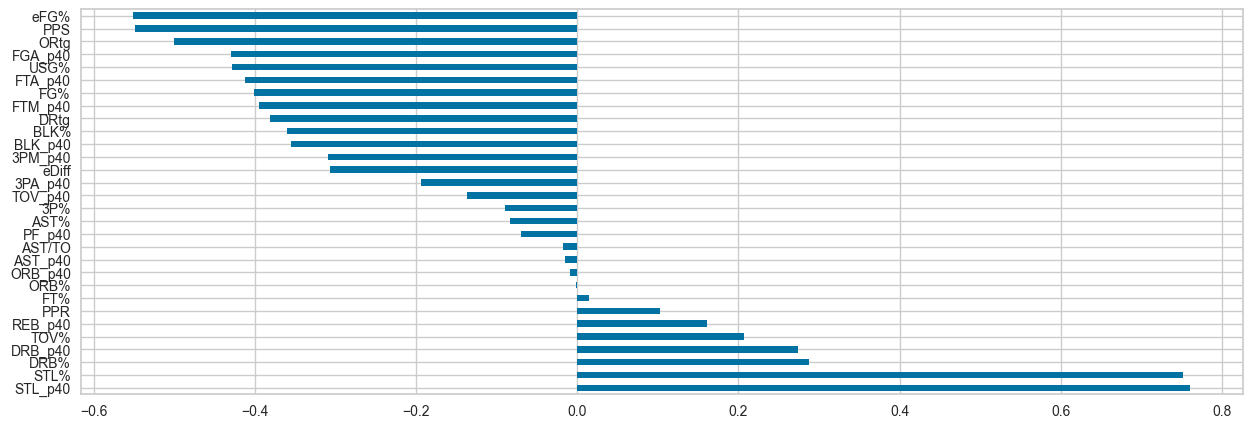

In [94]:
df3[2].sort_values(0,ascending=False).head(30).plot.barh(figsize=(15,5))

***
***
***
# MERGE DATASET FINALE CLUSTERING

In [95]:
df_A.head(2)

Player Team       FG%       3P%       FT%       TS%      eFG%  \
2  Danilo Andjusic  ASM -0.446018  0.716923  0.749325  0.498790 -0.085289   
4     Dwayne Bacon  ASM -0.170254  0.673779  0.254059 -0.229675 -0.281745   

       ORB%      DRB%      AST%  ...   DRB_p40   REB_p40   AST_p40   STL_p40  \
2 -0.846175 -0.989197 -0.575263  ... -0.994494 -1.010797 -0.490372 -1.186736   
4 -0.682585 -0.042647 -0.649654  ... -0.053507 -0.378176 -0.651207  0.656544   

    BLK_p40   TOV_p40    PF_p40    AST/TO  cluster  skills_cluster  
2 -0.646487  0.722098  0.149163 -0.984329        1               2  
4 -0.784926 -0.454556 -0.095505 -0.621829        1               0  

[2 rows x 37 columns]

In [96]:
df_A.shape

(75, 37)

In [97]:
df_D.head(2)

Player Team       FG%       3P%       FT%       TS%  \
3   Kostas Antetokounmpo  LYV  2.554292  0.537154 -1.550124  1.735807   
10        Marek Blazevic  ZAL  0.844556 -2.339154  0.388488  0.485046   

        eFG%      ORB%      DRB%      AST%  ...   DRB_p40   REB_p40   AST_p40  \
3   2.245991  0.813095  0.768681 -1.021611  ...  0.779694  0.853953 -1.071423   
10  0.071876  2.425625  0.053939 -0.001386  ... -0.036433  1.104475 -0.251459   

     STL_p40   BLK_p40   TOV_p40    PF_p40    AST/TO  cluster  skills_cluster  
3   0.774345  2.978558  0.197863  2.015487 -1.482427        0               1  
10 -0.008145  0.058479  1.709608  3.163439 -1.049721        0               0  

[2 rows x 37 columns]

In [98]:
df_D.shape

(49, 37)

In [99]:
df_C.head(2)

Player Team       FG%       3P%       FT%       TS%      eFG%  \
0  Alberto Abalde  RMB -0.589415  0.235142 -0.120928 -0.628269 -0.582978   
1  James Anderson  EFE  0.701159  1.083652  1.004033  0.966108  0.936283   

       ORB%      DRB%      AST%  ...   DRB_p40   REB_p40   AST_p40   STL_p40  \
0 -0.308665  0.363017 -0.054523  ...  0.523368  0.173640  0.069137 -0.415447   
1  0.649505  0.865268 -0.883456  ...  1.038888  0.916432 -0.822181  0.170813   

    BLK_p40   TOV_p40    PF_p40    AST/TO  cluster  skills_cluster  
0 -0.784926  0.114621 -0.134564 -0.031573        2               2  
1 -0.408176 -1.369543 -0.278294  0.069784        2               0  

[2 rows x 37 columns]

In [100]:
df_C.shape

(83, 37)

In [101]:
dffC = df_C[['Player','Team','skills_cluster']]
dffD = df_D[['Player','Team','skills_cluster']]
dffA = df_A[['Player','Team','skills_cluster']]

In [102]:
dffC.skills_cluster.unique()

array([2, 0, 1])

In [103]:
dffA.skills_cluster.unique()

array([2, 0, 1])

In [104]:
dffD.skills_cluster.unique()

array([1, 0])

## Assegno a ogni cluster un valore da 0 a 8 in modo da evitare duplicati label

In [105]:
dffA = dffA.rename(columns={'skills_cluster':'cluster'})

mapp_C = {0:3,1:4,2:5}
mapp_D = {0:6,1:7}

dffC['cluster'] = dffC.skills_cluster.map(mapp_C)
dffD['cluster'] = dffD.skills_cluster.map(mapp_D)

In [106]:
dffD = dffD.drop(columns=['skills_cluster'])
dffC = dffC.drop(columns=['skills_cluster'])

## Concateno e salvo il dataset finale del clusteringm

In [109]:
df_final = pd.concat([dffD,dffC,dffA])
df_final.to_csv('data/dataset_finale_clustering.csv')

In [110]:
df_analysis_cluster = df_final
df_analysis_cluster

Player  Team  cluster
3    Kostas Antetokounmpo   LYV        7
10         Marek Blazevic   ZAL        6
12          Joel Bolomboy  CSKA        6
13           Devin Booker   FEN        6
24          Matt Costello  BASK        6
..                    ...   ...      ...
191          Corey Walden   BAY        2
199      Scottie Wilbekin   MAC        1
200      Derrick Williams   MAC        0
202          Nate Wolters   ZVE        1
203    Guerschon Yabusele   RMB        2

[207 rows x 3 columns]

## Suddivido ogni cluster per poter analizzarne la composizione e la tipologia dei giocaatori al loto interno

In [111]:
df_A0 = df_analysis_cluster[df_analysis_cluster['cluster']==0]
df_A1 = df_analysis_cluster[df_analysis_cluster['cluster']==1]
df_A2 = df_analysis_cluster[df_analysis_cluster['cluster']==2]
df_C3 = df_analysis_cluster[df_analysis_cluster['cluster']==3]
df_C4 = df_analysis_cluster[df_analysis_cluster['cluster']==4]
df_C5 = df_analysis_cluster[df_analysis_cluster['cluster']==5]
df_D6 = df_analysis_cluster[df_analysis_cluster['cluster']==6]
df_D7 = df_analysis_cluster[df_analysis_cluster['cluster']==7]

***
***

## Dopo aver osservato le statistiche ora analizza composizione di ogni cluster e crea etichetta in base alla tipologia di giocatore al loro interno

***
## A

In [113]:
df_A0.head(57)

Player  Team  cluster
4              Dwayne Bacon   ASM        0
20            Isaiah Canaan   UNI        0
23             Will Clyburn  CSKA        0
26             Troy Daniels   MIL        0
27              Gigi Datome   MIL        0
31          Malcolm Delaney   MIL        0
36            Ognjen Dobric   ZVE        0
37             Tyler Dorsey   OLY        0
47        Simone Fontecchio  BASK        0
62             Sehmus Hazer   FEN        0
65            Mario Hezonja   UNI        0
66             Cory Higgins   FCB        0
67          Darrun Hilliard   BAY        0
69           Austin Hollins   ZVE        0
75           Ognjen Jaramaz   BAY        0
80           Nikola Kalinic   ZVE        0
95   Giannoulis Larentzakis   OLY        0
103            Sergio Llull   RMB        0
109        Gabriel Lundberg  CSKA        0
111        Melih Mahmutoglu   FEN        0
117               O.J. Mayo   UNI        0
134            Andreas Obst   BAY        0
141      Ioannis Papapetrou   PAN        0
163       Tornike Shengelia  CSKA        0
164          Shavon Shields   MIL        0
171            Jaleen Smith   BER        0
181          Deshaun Thomas   BAY        0
200        Derrick Williams   MAC        0

In [114]:
df_A1.head(30)

Player  Team  cluster
5         Wade Baldwin IV  BASK        1
9             Tamir Blatt   BER        1
16          Lorenzo Brown   UNI        1
30          Nando De Colo   FEN        1
52         Jayson Granger  BASK        1
56          Marko Guduric   FEN        1
64         Thomas Heurtel   RMB        1
72        Nikola Ivanovic   ZVE        1
73             Mike James   ASM        1
78       Rokas Jokubaitis   FCB        1
79            Chris Jones   LYV        1
81       Mantas Kalnietis   ZAL        1
94   Nicolas Laprovittola   FCB        1
96           Shane Larkin   EFE        1
100             Paris Lee   ASM        1
101      Lukas Lekavicius   ZAL        1
104              Maodo Lo   BER        1
106           Jordan Loyd   ZEN        1
110           Daryl Macon   PAN        1
120         Vasilje Micic   EFE        1
131       Nemanja Nedovic   PAN        1
135            Elie Okobo   LYV        1
156      Sergio Rodriguez   MIL        1
165          Alexey Shved  CSKA        1
170        Kostas Sloukas   OLY        1
173          Marco Spissu   UNI        1
199      Scottie Wilbekin   MAC        1
202          Nate Wolters   ZVE        1

In [115]:
df_A2.head(30)

Player  Team  cluster
2        Danilo Andjusic   ASM        2
6            Billy Baron   ZEN        2
7      Rodrigue Beaubois   EFE        2
21        Fabien Causeur   RMB        2
40       Marcus Eriksson   BER        2
48       Conner Frankamp   ZEN        2
49      Rokas Giedraitis  BASK        2
54       Marius Grigonis  CSKA        2
57        Daniel Hackett  CSKA        2
58            Devon Hall   MIL        2
88            Kyle Kuric   FCB        2
102         David Lighty   LYV        2
107       Vladimir Lucic   BAY        2
118  Shaquielle McKissic   OLY        2
122     Arturas Milaknis   ZAL        2
133       James Nunnally   MAC        2
189   Johannes Voigtmann  CSKA        2
191         Corey Walden   BAY        2
203   Guerschon Yabusele   RMB        2

## C

In [116]:
df_C3.head(50)

Player  Team  cluster
1         James Anderson   EFE        3
19       Angelo Caloiaro   MAC        3
22       Tyler Cavanaugh   ZAL        3
28       Dejan Davidovac   ZVE        3
32           Malte Delow   BER        3
46        Rudy Fernandez   RMB        3
60            Adam Hanga   RMB        3
70        William Howard   LYV        3
83    Leonidas Kaselakis   PAN        3
87       Nikita Kurbanov  CSKA        3
98      Stefan Lazarevic   ZVE        3
115       Sergi Martinez   FCB        3
116     Jonas Mattisseck   BER        3
129          Brock Motum   ASM        3
136         Louis Olinde   BER        3
138      Yakuba Ouattara   ASM        3
143          Alec Peters  BASK        3
149     Achille Polonara   FEN        3
152   Georgios Printezis   OLY        3
155      Giampaolo Ricci   MIL        3
161    Tadas Sedekerskis  BASK        3
178       Jeffery Taylor   RMB        3
183          Will Thomas   ASM        3
184           Ivan Ukhov  CSKA        3
186     Dimitri Uzinskiy   UNI        3
190  Andrey Vorontsevich   UNI        3

In [117]:
df_C4.head(30)

Player  Team  cluster
11      Lefteris Bochoridis   PAN        4
35             Antoine Diot   LYV        4
51               James Gist   LYV        4
53             Jerian Grant   MIL        4
61              Nigel Hayes   FCB        4
86           Dmitry Kulagin   ZEN        4
89            Arturs Kurucs  BASK        4
99             Branko Lazic   ZVE        4
105  Charles Lombahe-Kahudi   LYV        4
108      Karolis Lukosiunas   ZAL        4
112        Vanja Marinkovic  BASK        4
113         Stefan Markovic   ZVE        4
142          Kendrick Perry   PAN        4
144            Lamar Peters  BASK        4
153          Leon Radosevic   BAY        4
160           Tim Schneider   BER        4
162           Marial Shayok   FEN        4
169               Zan Sisko   BAY        4
174         Matthew Strazel   LYV        4
175        Janis Strelnieks   ZAL        4
179          Kameron Taylor   MAC        4
182            Khyri Thomas   MAC        4
193             Tai Webster   ZAL        4
196          Leo Westermann   ASM        4

In [119]:
df_C5.head(30)

Player Team  cluster
0          Alberto Abalde  RMB        5
8              Ben Bentil  MIL        5
14       Jarrell Brantley  UNI        5
15             John Brown  UNI        5
17          Elijah Bryant  EFE        5
18          Nick Calathes  FCB        5
34      John DiBartolomeo  MAC        5
42           Keenan Evans  MAC        5
50           Niels Giffey  ZAL        5
63          Pierria Henry  FEN        5
74       Paulius Jankunas  ZAL        5
82         Sergey Karasev  ZEN        5
84          Marcos Knight  LYV        5
91   Mindaugas Kuzminskas  ZEN        5
92           Paul Lacombe  LYV        5
137      Dylan Osetkowski  LYV        5
140   Kostas Papanikolaou  OLY        5
146        Dyshawn Pierre  FEN        5
150       Mateusz Ponitka  ZEN        5
159      Howard Sant-Roos  PAN        5
166            Luke Sikma  BER        5
167       Krunoslav Simon  EFE        5
168       Chris Singleton  EFE        5
172         Rolands Smits  FCB        5
180     Johannes Thiemann  BER        5
185      Edgaras Ulanovas  ZAL        5
192         Thomas Walkup  OLY        5
194      Nick Weiler-Babb  BAY        5
197           Aaron White  ZVE        5
198           Okaro White  PAN        5

***
***
# D

In [120]:
df_D.skills_cluster.value_counts()

0    32
1    17
Name: skills_cluster, dtype: int64

In [121]:
df_D6.head(50)

Player  Team  cluster
10       Marek Blazevic   ZAL        6
12        Joel Bolomboy  CSKA        6
13         Devin Booker   FEN        6
24        Matt Costello  BASK        6
25       Oscar da Silva   BER        6
29       Brandon Davies   FCB        6
33         Alpha Diallo   ASM        6
39         Steven Enoch  BASK        6
41         Jeremy Evans   PAN        6
43           Dante Exum   FCB        6
68           Kyle Hines   MIL        6
71       Othello Hunter   BAY        6
76   Livio Jean-Charles   OLY        6
93          Ben Lammers   BER        6
97    Joffrey Lauvergne   ZAL        6
119        Nicolo Melli   MIL        6
121       Jordan Mickey   ZEN        6
124      Nikola Mirotic   FCB        6
125     Kostas Mitoglou   MIL        6
126       Luka Mitrovic   ZVE        6
127      Adrien Moerman   EFE        6
128  Donatas Motiejunas   ASM        6
132        Landry Nnoko  BASK        6
145      Filip Petrusev   EFE        6
147        Tibor Pleiss   EFE        6
154      Jalen Reynolds   MAC        6
157     Augustine Rubit   BAY        6
158        Sertac Sanli   FCB        6
176    Kaleb Tarczewski   MIL        6
187          Jan Vesely   FEN        6
188      Sasha Vezenkov   OLY        6
195   Victor Wembanyama   LYV        6

In [122]:
df_D7.head(50)

Player  Team  cluster
3    Kostas Antetokounmpo   LYV        7
38         Bryant Dunston   EFE        7
44         Moustapha Fall   OLY        7
45        Youssoupha Fall   LYV        7
55       Arturas Gudaitis   ZEN        7
59             Donta Hall   ASM        7
77           Tonye Jekiri   UNI        7
85        Christ Koumadje   BER        7
90           Ognen Kuzmic   ZVE        7
114         Hassan Martin   OLY        7
123      Nikola Milutinov  CSKA        7
130             Josh Nebo   ZAL        7
139    George Papagiannis   PAN        7
148       Vincent Poirier   RMB        7
151        Alex Poythress   ZEN        7
177           Edy Tavares   RMB        7
204            Ante Zizic   MAC        7

### Assegna un nome a ogni cluster in base alla tua analisi precedente: 

In [123]:
mapp_Role_Cluster ={0:'prova1', 
                    1:'prova2',
                    2:'prova3',
                    3:'prova4',
                    4:'prova5',
                    5:'prova6',
                    6:'prova7',
                    7:'prova8',
                    8:'prova9'
                   }

In [124]:
df_analysis_cluster['cluster_name'] = df_analysis_cluster.cluster.map(mapp_Role_Cluster)

In [125]:
df_analysis_cluster

Player  Team  cluster cluster_name
3    Kostas Antetokounmpo   LYV        7       prova8
10         Marek Blazevic   ZAL        6       prova7
12          Joel Bolomboy  CSKA        6       prova7
13           Devin Booker   FEN        6       prova7
24          Matt Costello  BASK        6       prova7
..                    ...   ...      ...          ...
191          Corey Walden   BAY        2       prova3
199      Scottie Wilbekin   MAC        1       prova2
200      Derrick Williams   MAC        0       prova1
202          Nate Wolters   ZVE        1       prova2
203    Guerschon Yabusele   RMB        2       prova3

[207 rows x 4 columns]

## Creo dataframe della composizione di ogni squadra in base alla tipologia di giocatore emersa dai cluster

In [126]:
df_composizione_squadre = df_analysis_cluster.groupby(['Team','cluster_name']).count()['Player'].to_frame().rename(columns={'Player':'count'})
df_composizione_squadre = df_composizione_squadre.reset_index()
df_pivot= df_composizione_squadre.pivot(index='Team',columns='cluster_name',values='count')
df_pivot = df_pivot.fillna(0)
df_pivot = df_pivot.reset_index().reset_index(drop=True)
df_pivot =df_pivot.rename_axis(None, axis=1)
df_pivot = df_pivot.set_index('Team')
df_pivot

prova1  prova2  prova3  prova4  prova5  prova6  prova7  prova8
Team                                                                
ASM      1.0     2.0     1.0     3.0     1.0     0.0     2.0     1.0
BASK     1.0     2.0     1.0     2.0     3.0     0.0     3.0     0.0
BAY      4.0     0.0     2.0     0.0     2.0     1.0     2.0     0.0
BER      1.0     2.0     1.0     3.0     1.0     3.0     2.0     1.0
CSKA     3.0     1.0     3.0     2.0     0.0     0.0     1.0     1.0
EFE      0.0     2.0     1.0     1.0     0.0     3.0     3.0     1.0
FCB      1.0     2.0     1.0     1.0     1.0     2.0     4.0     0.0
FEN      2.0     2.0     0.0     1.0     1.0     2.0     2.0     0.0
LYV      0.0     2.0     1.0     1.0     4.0     3.0     1.0     2.0
MAC      1.0     1.0     1.0     1.0     2.0     2.0     1.0     1.0
MIL      4.0     1.0     1.0     1.0     1.0     1.0     4.0     0.0
OLY      2.0     1.0     1.0     1.0     0.0     2.0     2.0     2.0
PAN      1.0     2.0     0.0     1.0     2.0     2.0     1.0     1.0
RMB      1.0     1.0     2.0     3.0     0.0     2.0     0.0     2.0
UNI      3.0     2.0     0.0     2.0     0.0     2.0     0.0     1.0
ZAL      0.0     2.0     1.0     1.0     3.0     3.0     2.0     1.0
ZEN      0.0     1.0     2.0     0.0     1.0     4.0     1.0     2.0
ZVE      3.0     2.0     0.0     2.0     2.0     1.0     1.0     1.0

In [127]:
#df_pivot.to_csv('data/composizione_team_clustering.csv')

# GRAFICI CONFRONTO

In [128]:
colors = ['#9EBD6E','#81a094','#775b59','#32161f', '#946846', '#E3C16F', '#fe938c', '#E6B89C','#EAD2AC',
          '#DE9E36', '#4281A4','#37323E','#95818D' ]

In [129]:
import matplotlib.patches as mpatches
def cluster_comparison_bar(X_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = X_comparison.index
    ncols = 10
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(30,5), dpi=400)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        X_comparison[X_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors[0:10],
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = X_comparison.columns.to_list()
    c_colors = colors[0:10]
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors[0:df_composizione_squadre.cluster_name.nunique()],
                                                                  X_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 1.2)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1.1)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

## Confronto Team in base alla loro tipologia giocatori 

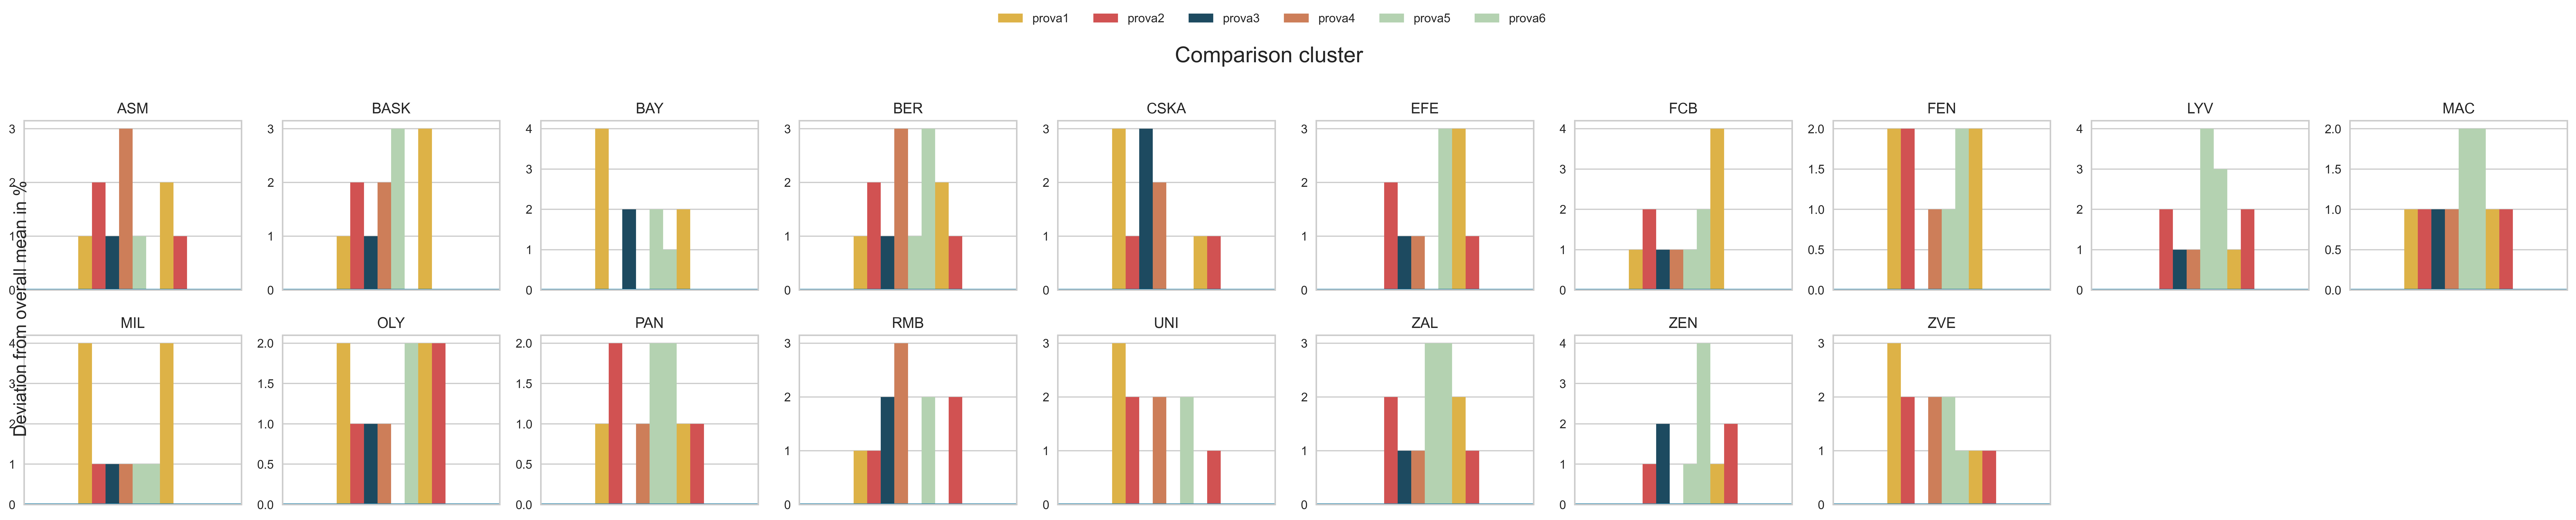

In [130]:
cluster_comparison_bar(df_pivot, cluster_colors, title="Comparison cluster ")

In [131]:
name_cluster = list(np.array(df_pivot.columns))


In [132]:
#pip install plotly
import plotly.graph_objects as go
import plotly.offline as pyo

# Creazione radar con suddivisione media cluster posizioni squadre top classifica

## Seleziona i Team che preferisci utilizzare come benchmark di riferimento:  
- creazione indice composizione media dei team selezionati

In [133]:
media_per_cluster = list(df_pivot.loc[['ASM','BASK','BAY','CSKA','EFE']].describe().loc['mean'].values)
media_per_cluster 

[1.8, 1.4, 1.6, 1.6, 1.2, 0.8, 2.2, 0.6]

### Seleziona squadra da confrontare con benchmark 

In [134]:
squadra = list(df_pivot.loc['UNI'].values)
squadra

[3.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0]

In [135]:
categories = list(np.array(df_pivot.columns))
categories = [*categories, categories[0]]

media_squadre = media_per_cluster
squadra = squadra

restaurant_1 = [*media_squadre, media_squadre[0]]
restaurant_2 = [*squadra, squadra[0]]
#restaurant_3 = [*restaurant_3, restaurant_3[0]]


fig = go.Figure(
    data=[
        go.Scatterpolar(r=restaurant_1, theta=categories, fill='toself', name='TOP 5 Team Benchmark'),
        go.Scatterpolar(r=squadra, theta=categories, fill='toself', name='Squadra da confrontare')
        #go.Scatterpolar(r=restaurant_3, theta=categories, fill='toself', name='Restaurant 3')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='TOP 5 composizione squadra per cluster'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

pyo.iplot(fig)